# Imports and Functions

In [1]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq, eigh, norm, eigvalsh
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import hbar, elementary_charge, speed_of_light, Boltzmann

from itertools import product, combinations
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
def order(number):
    return np.floor(np.log10(number))


def get_wide_plot(parameters=plt.rcParams):
    wide_plt_params = {
        'figure.figsize': (4, 3),
        'figure.dpi': 300,
        'legend.fontsize': 7,
        'axes.labelsize': 10,
        'axes.titlesize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 2,
    }
    parameters.update(wide_plt_params)


def Phi(grid, wave_vector, phase=0, amplitude=1):
    return amplitude * np.sin(wave_vector * grid + phase)


def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)


def Phi_combine(A, B, wave_vector, grid):
    amplitude = np.sqrt(A ** 2 + B ** 2)
    phase = np.angle(A + 1j * B)
    single_field = amplitude * np.cos(wave_vector * grid - phase)
    return amplitude, phase, single_field


def Phi_combine_amps(A, B):
    """
    Remember that A is the amplitude of the COSINE
    and B is the amplitude of the SINE
    """
    return  np.sqrt(A ** 2 + B ** 2)


def Phi_combine_phases(A, B):
    return np.angle(A + 1j * B)


def atomic_transition(x='D1'):
    """
    I hated how the code looked commenting and uncommenting so, I've simply stuck this here in initial functions
    Is this necessary? No, but also I don't care.
    """
    common_transitions = {
        'D1': 794.978851,
        'D2': 780.251210,
    }
    return common_transitions[x]


ok = utlt.standardize_plots(plt.rcParams)

In [3]:
"""
Determine the atomic transition line, D1 or D2 lines for Rb-87 are the only ones supported currently
Then, call an instance of BEC to get physical params. 
This way wavelengths may be set precisely for dimensionless units.
Additionally this cell enables polarizability calculations for translating field strength to potential amplitude.
"""

transition = 'D2'
principal_wavelength = atomic_transition(transition)
# Resonance frequency of the atomic transition in units of 2π Hz to keep units consistent,
ω_0 = 2 * np.pi * speed_of_light / principal_wavelength * 1e9
print(f'As expected, the target transition frequency is 2π {ω_0 / (2 * np.pi) * 1e-12} THz')
# Model parameters for dimensionless units.
ω_x = 0.25 * 2 * np.pi  # From experimental cigar length params
ω_yz = 500 * 2 * np.pi
N = 2e3

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_yz,
    omega_z=ω_yz,
    number_of_atoms=N,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g


def get_alpha(wavelength):
    """Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in nm!!!
    """
    frequency = 2 * np.pi * speed_of_light * 1e9 / wavelength
    denominator = ω_0 ** 2 - frequency ** 2
    # This is the prefactor e^2/m, which is of the total order 10^-13
    prefactor = 1.602176634 ** 2 / 1.44316060
    gfo = order(np.abs(denominator))
    denominator /= 10 ** gfo
    alpha_order = -13 - gfo
    return prefactor / denominator, alpha_order


def get_dimless_alpha(wavelength):
    """Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in nm!!!
    """
    # Here we apply convert_time intead of dimless time because frequency is inverse time
    frequency = gpe.convert_time(2 * np.pi * speed_of_light * 1e9 / wavelength, 0)
    denominator = gpe.convert_time(ω_0, 0) ** 2 - frequency ** 2
    gfo = order(np.abs(denominator))
    denominator /= 10 ** gfo
    return 1 / denominator, -gfo


def f2V_scaling(wavelength):
    """
    Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in meters!!!
    """
    frequency = 2 * np.pi * speed_of_light / wavelength 
    gfo = order(frequency)
    frequency /= 10 ** gfo
    ω0_orderless = ω_0 / 10 ** gfo
    α = 1.602176634 ** 2 / 1.4431606    # the order of magnitude, 10^-13, will be added in the next line.
    return (0.5 * α / (ω0_orderless ** 2 - frequency ** 2)), (-13 - (gfo * 2))




As expected, the target transition frequency is 2π 384.225559868084 THz


# Params defined here

In [4]:
"""
Define Laser Params and the simulation grid
"""
# Control Amplitudes (in nm)
λ_control = np.array([702, 728, 780])
Per = np.array(0.5 * λ_control)
#λ_control = np.array([800, 1200, 1600])
λ_min = min(λ_control)
# Target wavelength (equal to the width of the superoscillations window)
λ_target = 250 # 0.45 * min([principal_wavelength, λ_min])  
# Wavevectors in dimensionless units for computation purposes
k_target = 2 * np.pi / gpe.dimless_x(λ_target, -9)
k = 2 * np.pi * (gpe.dimless_x(λ_control, -9) ** -1)

# Set the dimensionless length of the window for superoscillations here
window = gpe.dimless_x(λ_target, -9)
# Limit the full range of pulse to the characteristic length
#x_lim = gpe.dimless_x(9, -6)
x_lim = gpe.dimless_x(np.lcm.reduce([int(_) for _ in λ_control]), -9)*0.5
print(f'Compare the characteristic length {gpe.L_x*1e6} μm vs the full window length: {2 * gpe.convert_x(x_lim, -6)} μm')
x_res = 2 ** 20
dx = 2 * x_lim / x_res

x = np.arange(-window/2, window/2, dx)
x_full = np.arange(-x_lim, x_lim, dx)
x_units = gpe.convert_x(x, -9)
x_unitz = gpe.convert_x(x_full, -9)

V_0 = gpe.dimless_energy(1, -3)


# Number of pulses
n = len(λ_control)
# Determine the error tolerance
eps = 1e-11
# For if you wish to pre-cool the BEC in a centered quadratic potential
pre_cooling = False


Compare the characteristic length 21.5685408388234 μm vs the full window length: 98.27999999999999 μm


# Naming Protocols and some constants

In [5]:
named_params = {
    'window_length': round(λ_target, 5),
    'max': round(max(λ_control), 5),
    'min': round(min(λ_control), 5),
    'precool': pre_cooling,
    'length':round(x_lim, 3),
}
if λ_min > principal_wavelength:
    beamcolor= 'Red'
else:
    beamcolor = 'Blue'
params = copy.deepcopy(named_params)
file_path, file_name = utlt.build_saves_tag(params_list=named_params,
                                            unique_identifier=f'Paper_{transition}-{beamcolor}-ThreePulsePaper_tinydx',
                                            parent_directory='Archive_Data/Superoscilations')

Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

You may be overwriting previous data (; n;)



In [6]:
############################################################
#
# It is important to calculate the Critical Temp for a BEC
# This ensures that simulations are actually a BEC, and not
# just wishful thinking. 
#
# T_c = (number density / ζ(3/2))^(2/3) * 2πħ^2 / m*kB
#
############################################################

# The volume in micrometers temporarily to avoid machine precision
# These changes to order of magitude are corrected for by removing orders of known quantities
# ħ = 1.054571817e-34, kB=1.380649e-23*1e-9nK/K, m_87Rb=1.4431609e-25, L_i∝1e-6, Volume∝1e-18
# (N/∝1e-18)^(2/3) → (N/orderless_volume)^(2/3)*1E02, 
# simply multiplying by orders, we get 1E02 * ((1e-34)^2 / (1e-23*1e-9*1e-25)) → 1E02 * 1e57 / 1e68 → 1E0, 10
volume = (gpe.L_x * 1e6) * (gpe.L_y * 1e6) * (gpe.L_z * 1e6)
number_density = N / volume 
ζ_32 = 2.61237534869    # Riemman Zeta function (3/2)
T_c = 10 * (number_density / ζ_32) ** (1.5) * 2 * np.pi * 1.054571817 ** 2 / (1.4431609 * 1.380649)


# Now print the parameters for the run so that simulations can guarantee T << T_c
print(f'T_c, the critical temperature, is {T_c} nK.\nThis will be checked when modeling experiment')
#print(f'The wavelength spacing is {λ_spacing * gpe.convert_x(λ_min, -9)} nm') # Not used currently
print(f'The conversion factor for dimensionless energy {gpe.dimless_energy(1, -9)}')
print(f'The target integrated Energy is {round(gpe.convert_energy(V_0, -9), 2)} nK, or ~{round(V_0, 2)} in dimensionless units.')
print(f'The characteristic length, L_x is {gpe.L_x *1e6} μm')
print(f'The transverse characteristic length, L_y, L_z is {gpe.L_y *1e6} μm')
print(f'The shortest wavelength for this for this run is {min(λ_control)} nm')

T_c, the critical temperature, is 66111.54888998118 nK.
This will be checked when modeling experiment
The conversion factor for dimensionless energy 83.3464764933103
The target integrated Energy is 1000000.0 nK, or ~83346476.49 in dimensionless units.
The characteristic length, L_x is 21.5685408388234 μm
The transverse characteristic length, L_y, L_z is 0.48228723491089454 μm
The shortest wavelength for this for this run is 702 nm


# Solving the eigenvalue equation begins here


In [7]:
#########################################################################
#
# Hand solved overlap matrix
#
#########################################################################
dim_α1, dim_α1_order = get_alpha(λ_control[0])
dim_α2, dim_α2_order = get_alpha(λ_control[1])
dim_α3, dim_α3_order = get_alpha(λ_control[2])
α1 = gpe.dimless_energy(dim_α1, dim_α1_order, units='J')
α2 = gpe.dimless_energy(dim_α2, dim_α2_order, units='J')
α3 = gpe.dimless_energy(dim_α3, dim_α3_order, units='J')
α2_order = order(np.abs(α2))
α1 *= 10 ** (-α2_order)
α2 *= 10 ** (-α2_order)
α3 *= 10 ** (-α2_order)

E0 = np.sin(k[0]*x)
f0 = np.sin(k[0]*x_full)
E1 = np.cos(k[0]*x)
f1 = np.cos(k[0]*x_full)
E2 = np.sin(k[1]*x)
f2 = np.sin(k[1]*x_full)
E3 = np.cos(k[1]*x)
f3 = np.cos(k[1]*x_full)
E4 = np.sin(k[2]*x)
f4 = np.sin(k[2]*x_full)
E5 = np.cos(k[2]*x)
f5 = np.cos(k[2]*x_full)

m01 = k[0] - k[1]
p01 = k[0] + k[1]
m02 = k[0] - k[2]
p02 = k[0] + k[2]
m12 = k[1] - k[2]
p12 = k[1] + k[2] 
xi = -0.5 * window
xf = 0.5 * window
zi = -x_lim
zf = x_lim
infin = 2 * x_lim
print(f'xi: {xi}, xf: {xf}, +/-infty: {x_lim}')

# This notation is awful and I don't care
a1a1 = α1 * (0.5 * window - (np.sin(2 * k[0] * xf) - np.sin(2 * k[0] * xi)) / (4 * k[0]))
a2a2 = α1 * (0.5 * window + (np.sin(2 * k[0] * xf) - np.sin(2 * k[0] * xi)) / (4 * k[0]))
a3a3 = α2 * (0.5 * window - (np.sin(2 * k[1] * xf) - np.sin(2 * k[1] * xi)) / (4 * k[1]))
a4a4 = α2 * (0.5 * window + (np.sin(2 * k[1] * xf) - np.sin(2 * k[1] * xi)) / (4 * k[1]))
a5a5 = α3 * (0.5 * window - (np.sin(2 * k[2] * xf) - np.sin(2 * k[2] * xi)) / (4 * k[2]))
a6a6 = α3 * (0.5 * window + (np.sin(2 * k[2] * xf) - np.sin(2 * k[2] * xi)) / (4 * k[2]))


a1a3 = a3a1 = 0.5 * (α1 + α2) * ((np.sin(m01 * xf) / (2 * m01) - np.sin(p01 * xf) / (2 * p01)) 
                                 - (np.sin(m01 * xi) / (2 * m01) - np.sin(p01 * xi) / (2 * p01)))
a1a5 = a5a1 = 0.5 * (α1 + α3) * ((np.sin(m02 * xf) / (2 * m02) - np.sin(p02 * xf) / (2 * p02)) 
                                 - (np.sin(m02 * xi) / (2 * m02) - np.sin(p02 * xi) / (2 * p02)))
a3a5 = a5a3 = 0.5 * (α2 + α3) * ((np.sin(m12 * xf) / (2 * m12) - np.sin(p12 * xf) / (2 * p12)) 
                                 - (np.sin(m12 * xi) / (2 * m12) - np.sin(p12 * xi) / (2 * p12)))
a2a4 = a4a2 = 0.5 * (α1 + α2) * ((np.sin(m01 * xf) / (2 * m01) + np.sin(p01 * xf) / (2 * p01)) 
                                 - (np.sin(m01 * xi) / (2 * m01) + np.sin(p01 * xi) / (2 * p01)))
a2a6 = a6a2 = 0.5 * (α1 + α3) * ((np.sin(m02 * xf) / (2 * m02) + np.sin(p02 * xf) / (2 * p02)) 
                                 - (np.sin(m02 * xi) / (2 * m02) + np.sin(p02 * xi) / (2 * p02)))
a4a6 = a6a4 = 0.5 * (α2 + α3) * ((np.sin(m12 * xf) / (2 * m12) + np.sin(p12 * xf) / (2 * p12)) 
                                 - (np.sin(m12 * xi) / (2 * m12) + np.sin(p12 * xi) / (2 * p12)))

a1a2 = a2a1 = 0
a1a4 = a4a1 = 0
a1a6 = a6a1 = 0
a2a3 = a3a2 = 0
a2a5 = a5a2 = 0
a3a4 = a4a3 = 0
a3a6 = a6a3 = 0
a4a5 = a5a4 = 0
a5a6 = a6a5 = 0

S = -0.5 / V_0 * np.array([[a1a1, a1a2, a1a3, a1a4, a1a5, a1a6], 
                           [a2a1, a2a2, a2a3, a2a4, a2a5, a2a6],
                           [a3a1, a3a2, a3a3, a3a4, a3a5, a3a6],
                           [a4a1, a4a2, a4a3, a4a4, a4a5, a4a6],
                           [a5a1, a5a2, a5a3, a5a4, a5a5, a5a6],
                           [a6a1, a6a2, a6a3, a6a4, a6a5, a6a6]
                          ])

# This notation is awful and I don't care
b1b1 = α1 * (0.5 * infin - (np.sin(2 * k[0] * zf) - np.sin(2 * k[0] * zi)) / (4 * k[0]))
b2b2 = α1 * (0.5 * infin + (np.sin(2 * k[0] * zf) - np.sin(2 * k[0] * zi)) / (4 * k[0]))
b3b3 = α2 * (0.5 * infin - (np.sin(2 * k[1] * zf) - np.sin(2 * k[1] * zi)) / (4 * k[1]))
b4b4 = α2 * (0.5 * infin + (np.sin(2 * k[1] * zf) - np.sin(2 * k[1] * zi)) / (4 * k[1]))
b5b5 = α3 * (0.5 * infin - (np.sin(2 * k[2] * zf) - np.sin(2 * k[2] * zi)) / (4 * k[2]))
b6b6 = α3 * (0.5 * infin + (np.sin(2 * k[2] * zf) - np.sin(2 * k[2] * zi)) / (4 * k[2]))


b1b3 = b3b1 = 0.5 * (α1 + α2) * ((np.sin(m01 * zf) / (2 * m01) - np.sin(p01 * zf) / (2 * p01)) 
                                 - (np.sin(m01 * zi) / (2 * m01) - np.sin(p01 * zi) / (2 * p01)))
b1b5 = b5b1 = 0.5 * (α1 + α3) * ((np.sin(m02 * zf) / (2 * m02) - np.sin(p02 * zf) / (2 * p02)) 
                                 - (np.sin(m02 * zi) / (2 * m02) - np.sin(p02 * zi) / (2 * p02)))
b3b5 = b5b3 = 0.5 * (α2 + α3) * ((np.sin(m12 * zf) / (2 * m12) - np.sin(p12 * zf) / (2 * p12)) 
                                 - (np.sin(m12 * zi) / (2 * m12) - np.sin(p12 * zi) / (2 * p12)))
b2b4 = b4b2 = 0.5 * (α1 + α2) * ((np.sin(m01 * zf) / (2 * m01) + np.sin(p01 * zf) / (2 * p01)) 
                                 - (np.sin(m01 * zi) / (2 * m01) + np.sin(p01 * zi) / (2 * p01)))
b2b6 = b6b2 = 0.5 * (α1 + α3) * ((np.sin(m02 * zf) / (2 * m02) + np.sin(p02 * zf) / (2 * p02)) 
                                 - (np.sin(m02 * zi) / (2 * m02) + np.sin(p02 * zi) / (2 * p02)))
b4b6 = b6b4 = 0.5 * (α2 + α3) * ((np.sin(m12 * zf) / (2 * m12) + np.sin(p12 * zf) / (2 * p12)) 
                                 - (np.sin(m12 * zi) / (2 * m12) + np.sin(p12 * zi) / (2 * p12)))

Sr = -0.5 / V_0 * np.array([[b1b1, 0, b1b3, 0, b1b5, 0], 
                           [0, b2b2, 0, b2b4, 0, b2b6],
                           [b3b1, 0, b3b3, 0, b3b5, 0],
                           [0, b4b2, 0, b4b4, 0, b4b6],
                           [b5b1, 0, b5b3, 0, b5b5, 0],
                           [0, b6b2, 0, b6b4, 0, b6b6]
                           ])
vals, vecs = eigh(S, Sr)
eigvalsh(Sr)


xi: -0.005795477818091424, xf: 0.005795477818091424, +/-infty: 2.2783182398481


array([1.06988313e-08, 1.06988313e-08, 1.69343182e-08, 1.69343182e-08,
       3.90870366e-06, 3.90870366e-06])

In [8]:
print(f'1: {α1}, 2: {α2}, order: 1e{int(α2_order)}')
print(vals)
print(vecs[:, 2])

1: -0.7827790499102236, 2: -1.238997896534312, order: 1e-9
[-3.84927474e-02 -1.61595384e-02  1.20822956e-10  6.51950339e-09
  2.07746491e-02  4.91401452e-02]
[ 5.90708411e+03 -1.34168966e-13 -6.08129232e+03  4.10864923e-13
  1.02652002e+01 -1.45550437e-14]


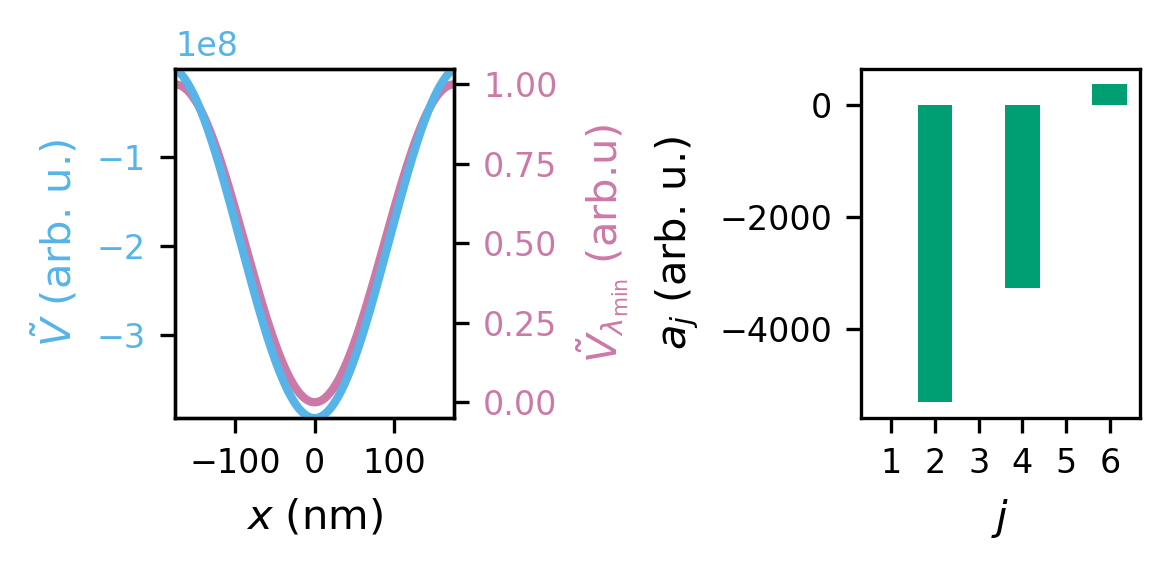

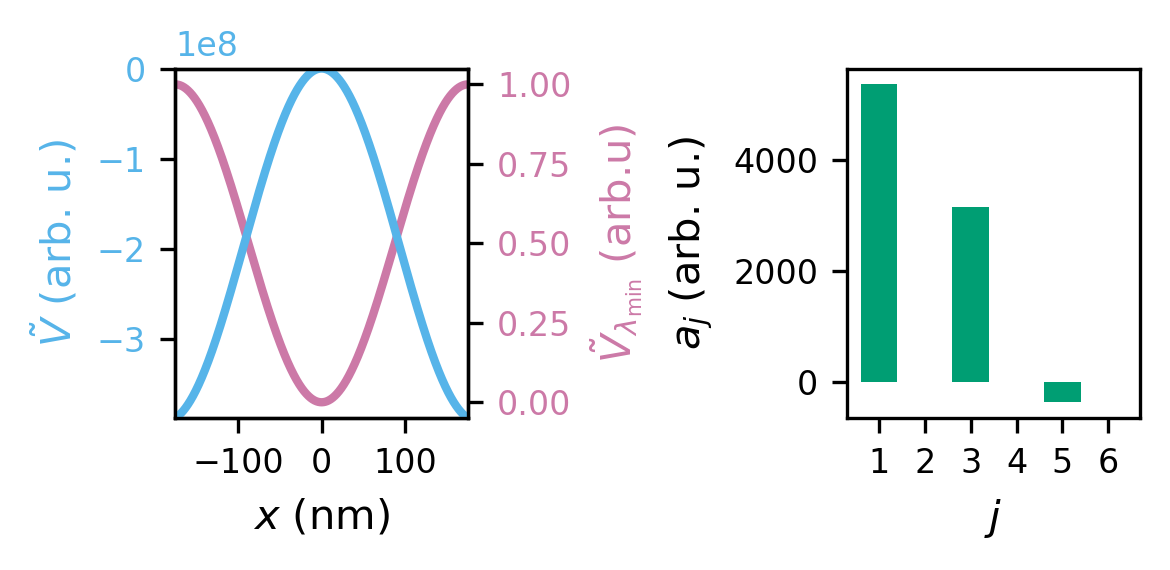

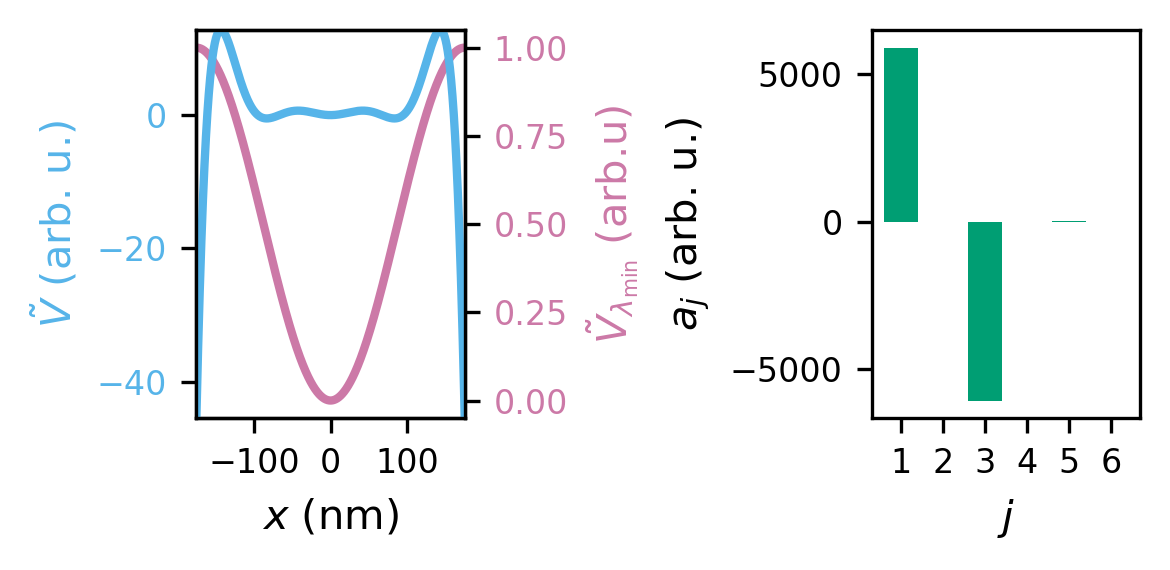

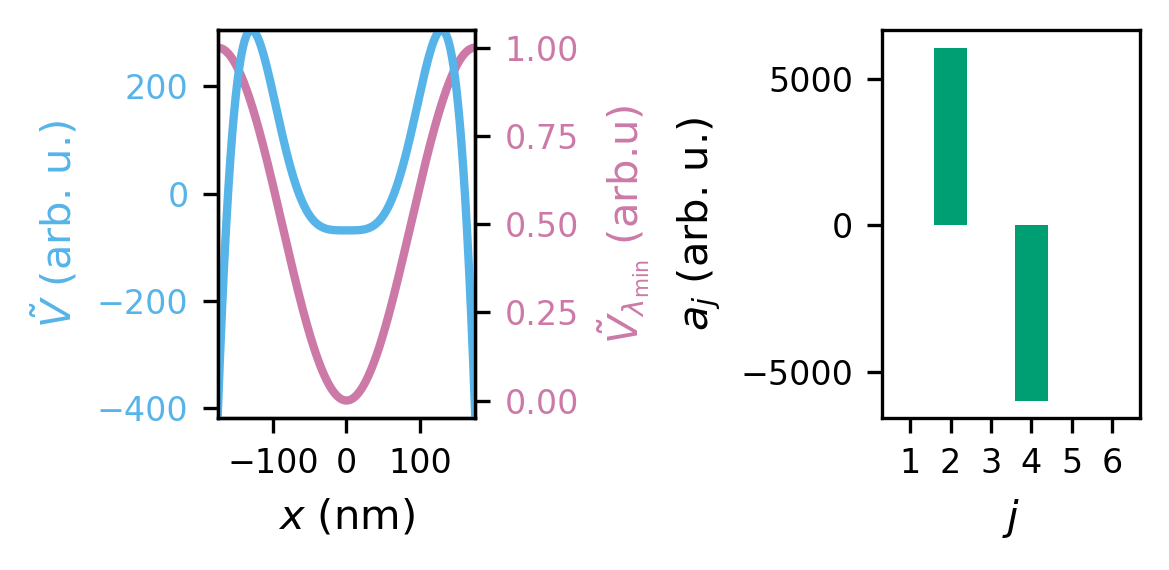

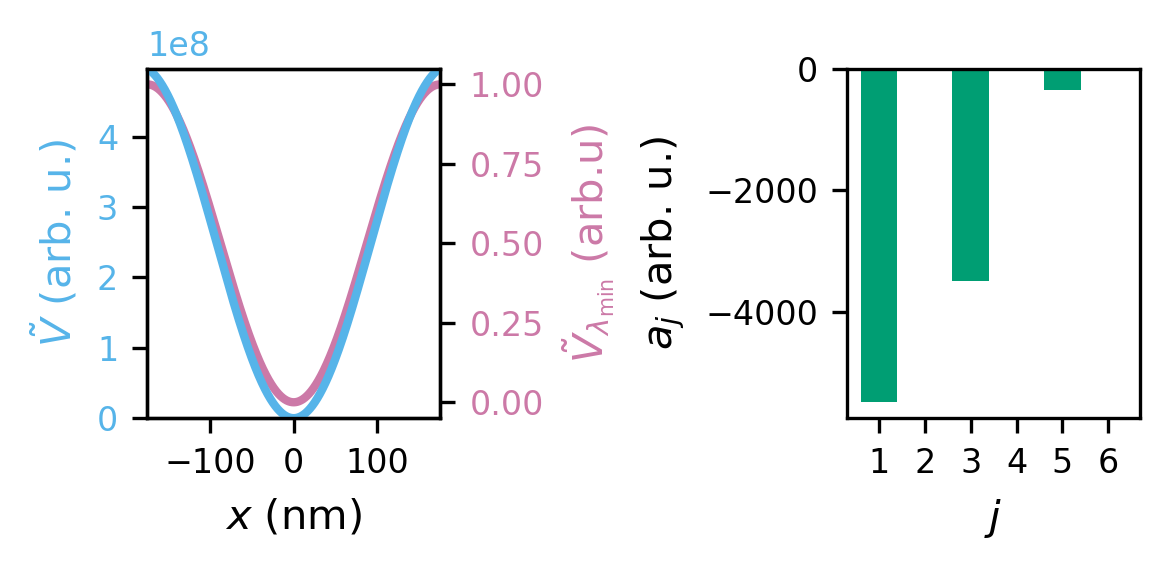

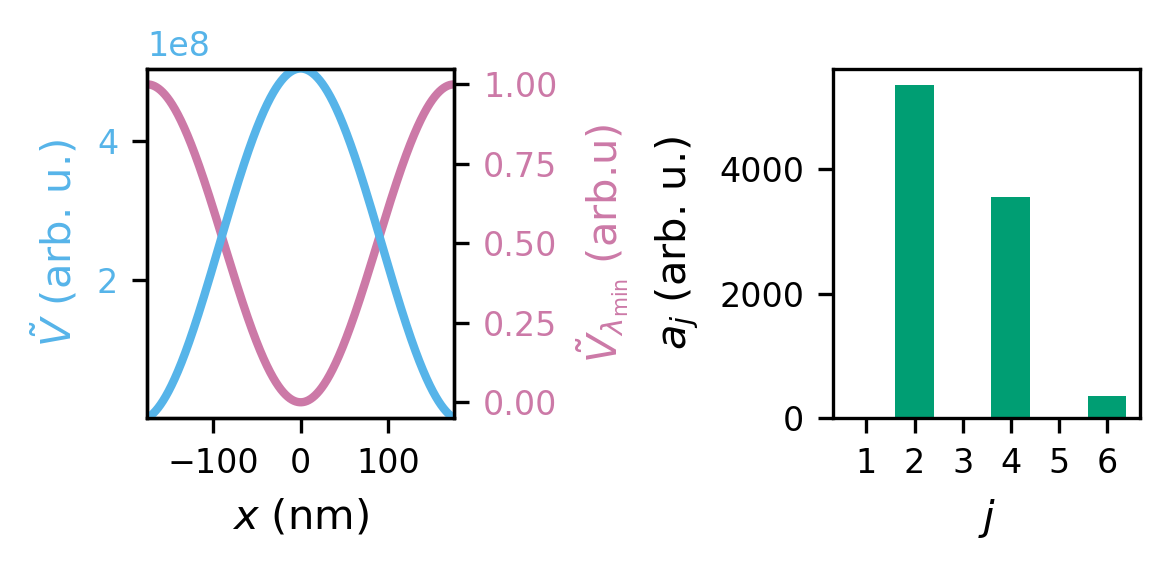

In [9]:
k_max = max(k)
largest_freq_pulse = Phi(x, max(k)) #, phase=np.pi/2)
largest_freq_pulsez = Phi(x_full, max(k)) #, phase=np.pi/2)
bounded = [-0.25 * λ_min, 0.25 * λ_min]


c1 = ok['blue']
c2 = ok['purple']
c3 = ok['green']
c4 = ok['amber']
c5 = ok['red']

get_wide_plot(plt.rcParams)

for _ in range(n*2):
    #fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    tV = np.array(-0.5 * (α1 * (eig_vector[0] * f0 + eig_vector[1] * f1) ** 2 
                          + α2 * (eig_vector[2] * f2 + eig_vector[3] * f3) ** 2
                          + α3 * (eig_vector[4] * f4 + eig_vector[5] * f5) ** 2
                          + (α1 + α2) * (eig_vector[0] * f0 + eig_vector[1] * f1) * (eig_vector[2] * f2 + eig_vector[3] * f3)
                          + (α1 + α3) * (eig_vector[0] * f0 + eig_vector[1] * f1) * (eig_vector[4] * f4 + eig_vector[5] * f5)
                          + (α2 + α3) * (eig_vector[2] * f2 + eig_vector[3] * f3) * (eig_vector[4] * f4 + eig_vector[5] * f5))
                 )
    rat_wind = 0.5 * λ_min / λ_target
    ampl_ind = [int(0.5 * (len(x_full) - rat_wind * len(x))), int(0.5 * (len(x_full) + rat_wind * len(x)))]
    ampl_ref = [min(tV[ampl_ind[0]:ampl_ind[1]]), max(tV[ampl_ind[0]:ampl_ind[1]])]
    #ax1.plot(x, tempV, color=c1)
    ax1.plot(x_unitz, tV, color=c1)  #, color=c4, linestyle='--')
    
    ax1.set_ylabel('$\\tilde{V}$ (arb. u.)', color=c1)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.set_xlim(bounded)
    ax1.set_ylim(ampl_ref)

    ax1.set_xlabel('$x$ (nm)')
    
    ax2 = ax1.twinx() 

    ax2.plot(x_unitz, largest_freq_pulsez ** 2, color=c2)
    ax2.set_ylabel('$\\tilde{V}_{\lambda_{\\rm min}}$ (arb.u)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(1, 2*n+1, 1), eig_vector, color=c3)
    #bar_width=0.75*(k[1]-k[0])
    #ax1.bar(k, combined_eig_vecs, width=bar_width, color=c4)
    #ax1.set_xticks(k)
    ax1.set_xticks(np.arange(1, 2*n+1, 1))
    #ax1.set_ylim(0.995 * min(combined_eig_vecs), 1.005 * max(combined_eig_vecs))
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_aBa_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

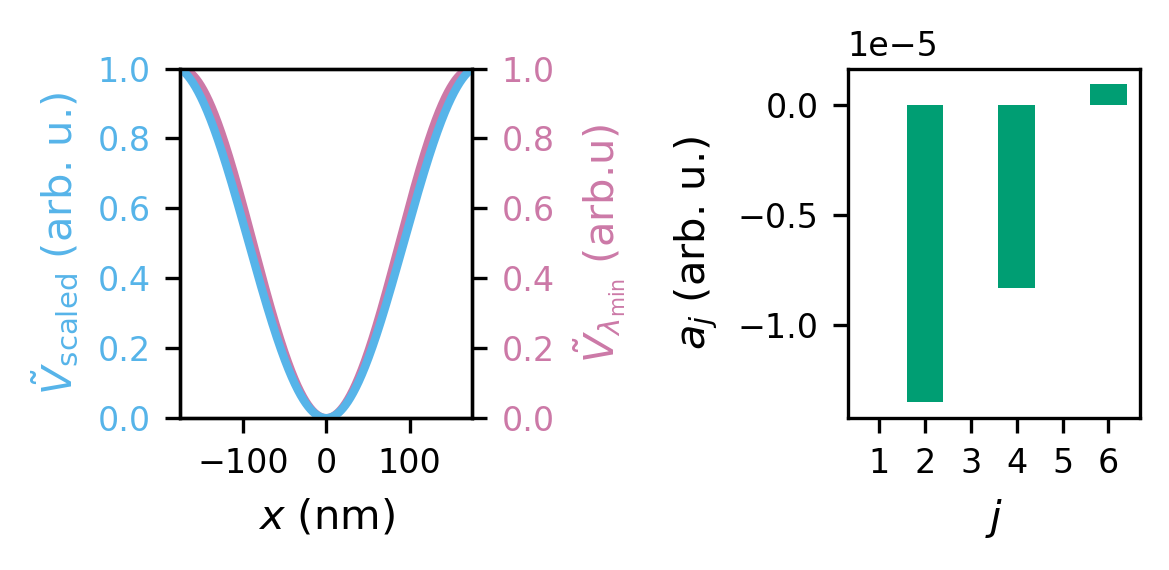

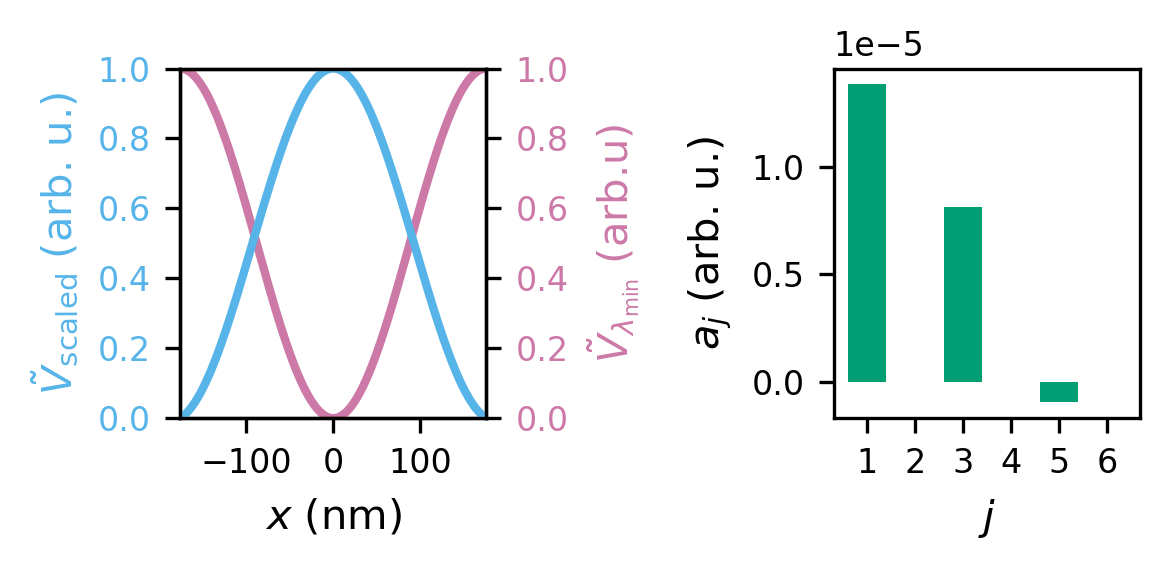

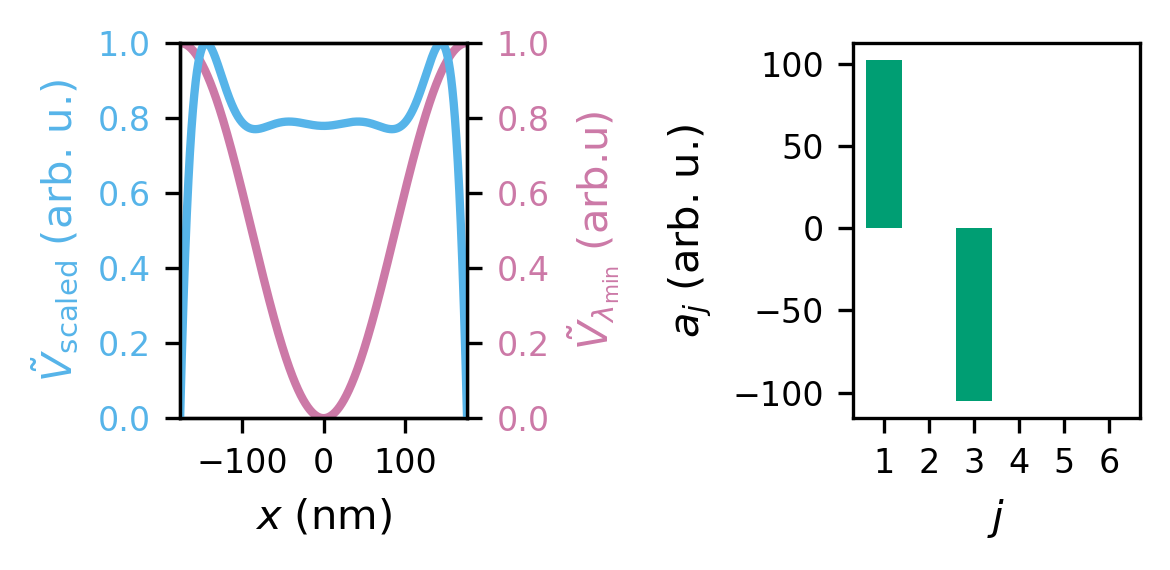

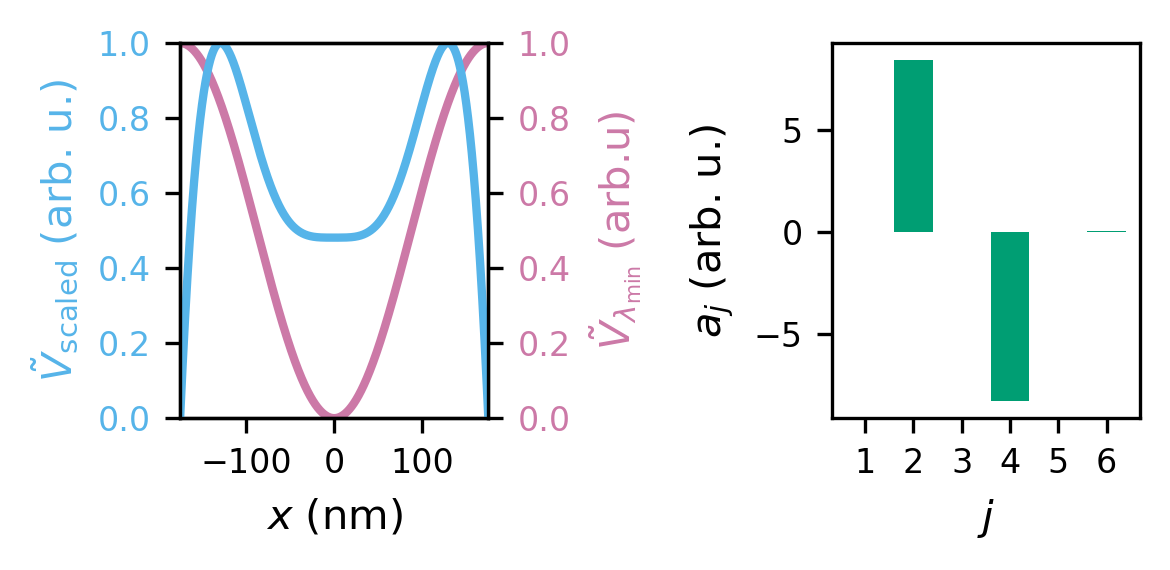

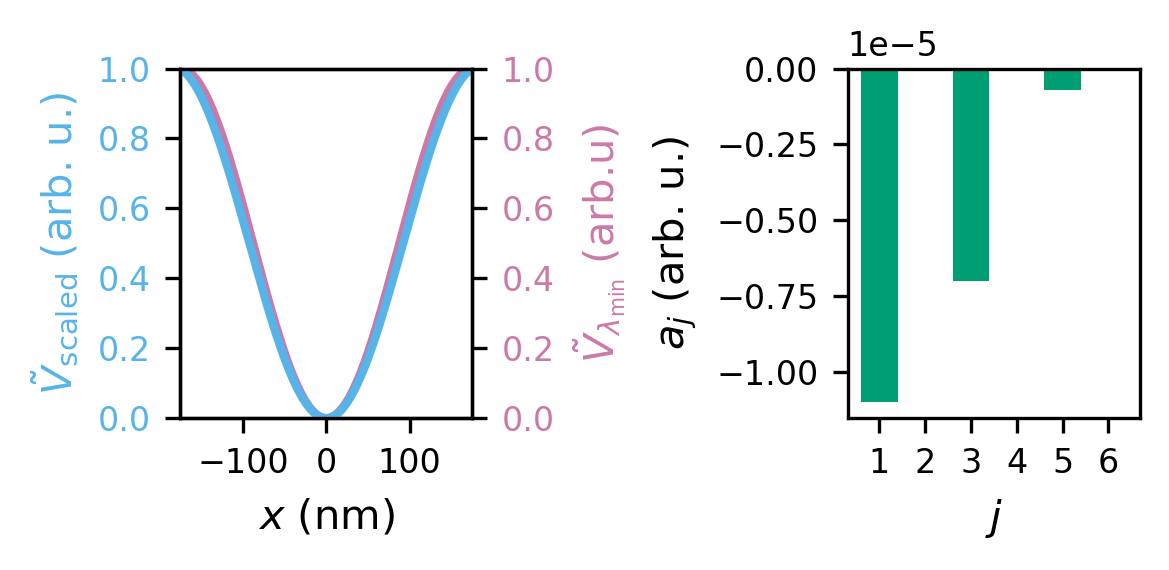

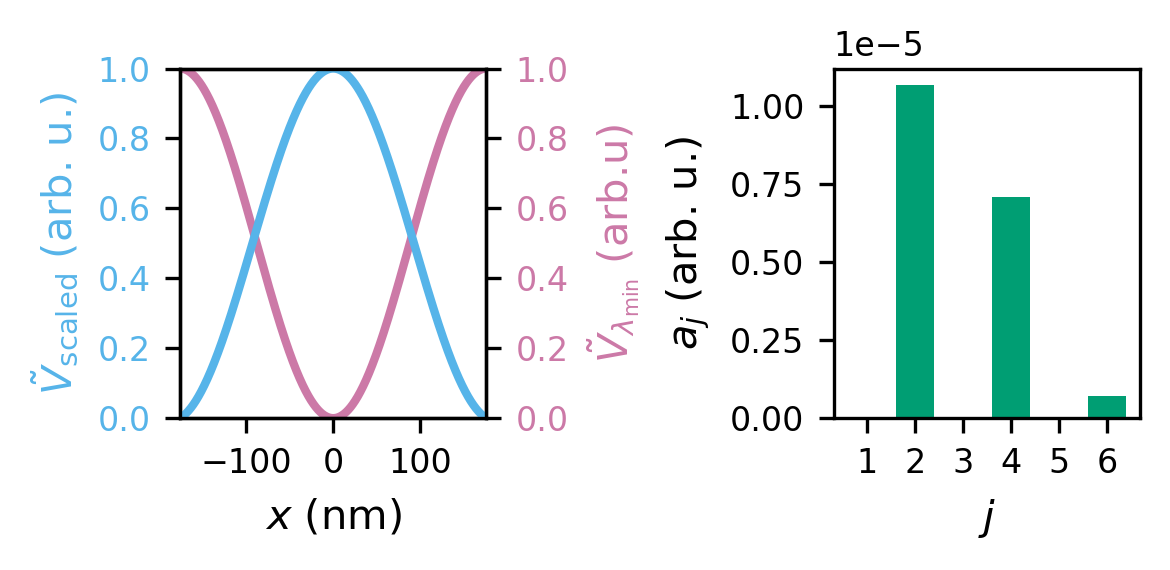

In [10]:
# Proper Comparison
for _ in range(n*2):
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    tV = np.array(-0.5 * (α1 * (eig_vector[0] * f0 + eig_vector[1] * f1) ** 2 
                          + α2 * (eig_vector[2] * f2 + eig_vector[3] * f3) ** 2
                          + α3 * (eig_vector[4] * f4 + eig_vector[5] * f5) ** 2
                          + (α1 + α2) * (eig_vector[0] * f0 + eig_vector[1] * f1) * (eig_vector[2] * f2 + eig_vector[3] * f3)
                          + (α1 + α3) * (eig_vector[0] * f0 + eig_vector[1] * f1) * (eig_vector[4] * f4 + eig_vector[5] * f5)
                          + (α2 + α3) * (eig_vector[2] * f2 + eig_vector[3] * f3) * (eig_vector[4] * f4 + eig_vector[5] * f5))
                 )
    l = np.where(x_unitz >= -0.25 * λ_min)[0][0]
    r = np.where(x_unitz <= 0.25 * λ_min)[0][-1]
    
    tV -= tV[l:r].min()
    renorm = 1 / tV[l:r].max()
    tV *= renorm
    ax1.plot(x_unitz, tV, color=c1)  #, color=c4, linestyle='--')
    
    ax1.set_ylabel('$\\tilde{V}_{\\rm scaled}$ (arb. u.)', color=c1)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.set_xlim(-0.25 * λ_min, 0.25 * λ_min)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('$x$ (nm)')
    
    ax2 = ax1.twinx() 

    ax2.plot(x_unitz, largest_freq_pulsez ** 2, color=c2)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('$\\tilde{V}_{\lambda_{\\rm min}}$ (arb.u)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot pulses
    ax1 = ax1__

    renorm_bars = eig_vector[:] * renorm
    ax1.bar(np.arange(1, 2*n+1, 1), renorm_bars, color=c3)
    ax1.set_xticks(np.arange(1, 2*n+1, 1))
    #ax1.set_ylim(0.995 * min(combined_eig_vecs), 1.005 * max(combined_eig_vecs))
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_Scaled_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

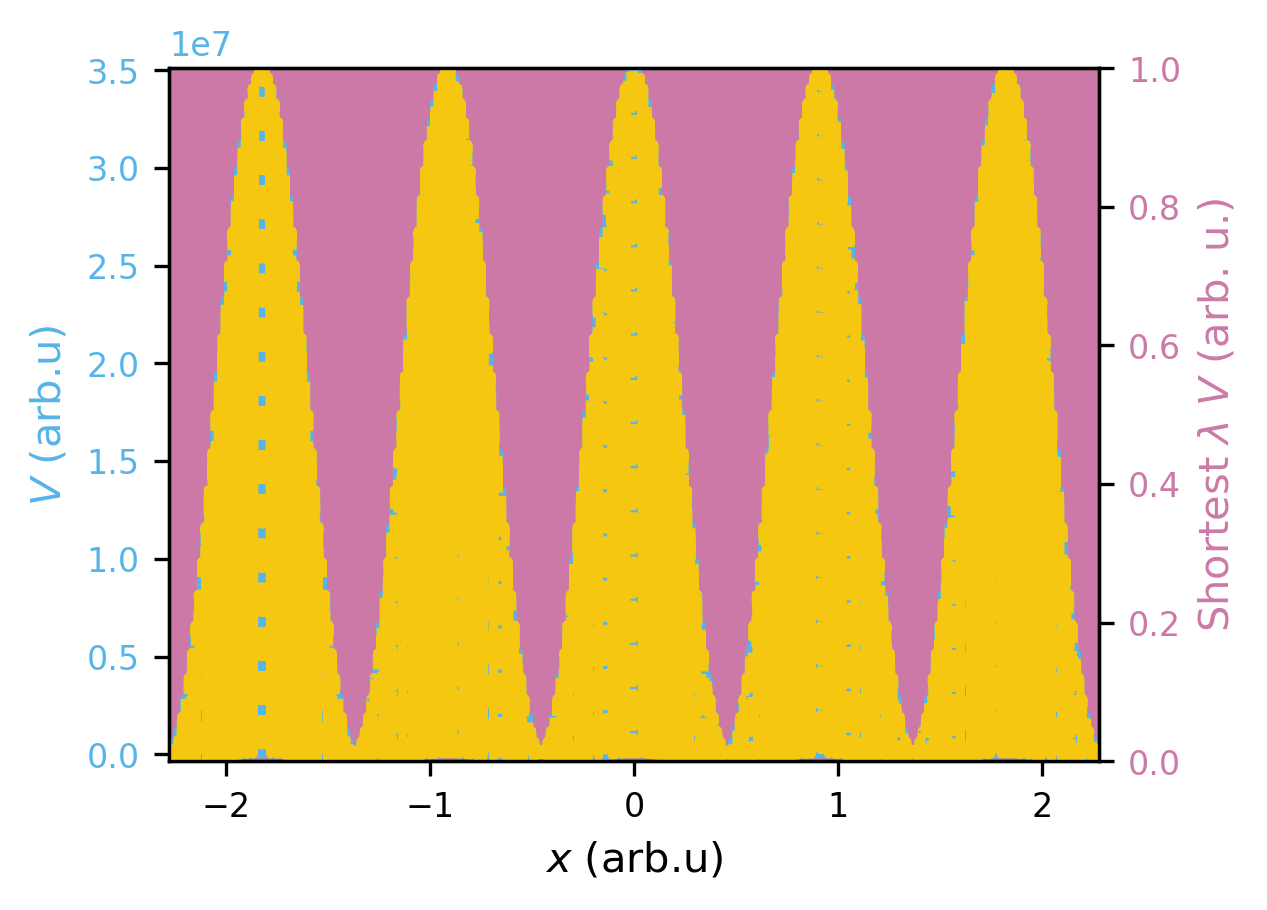

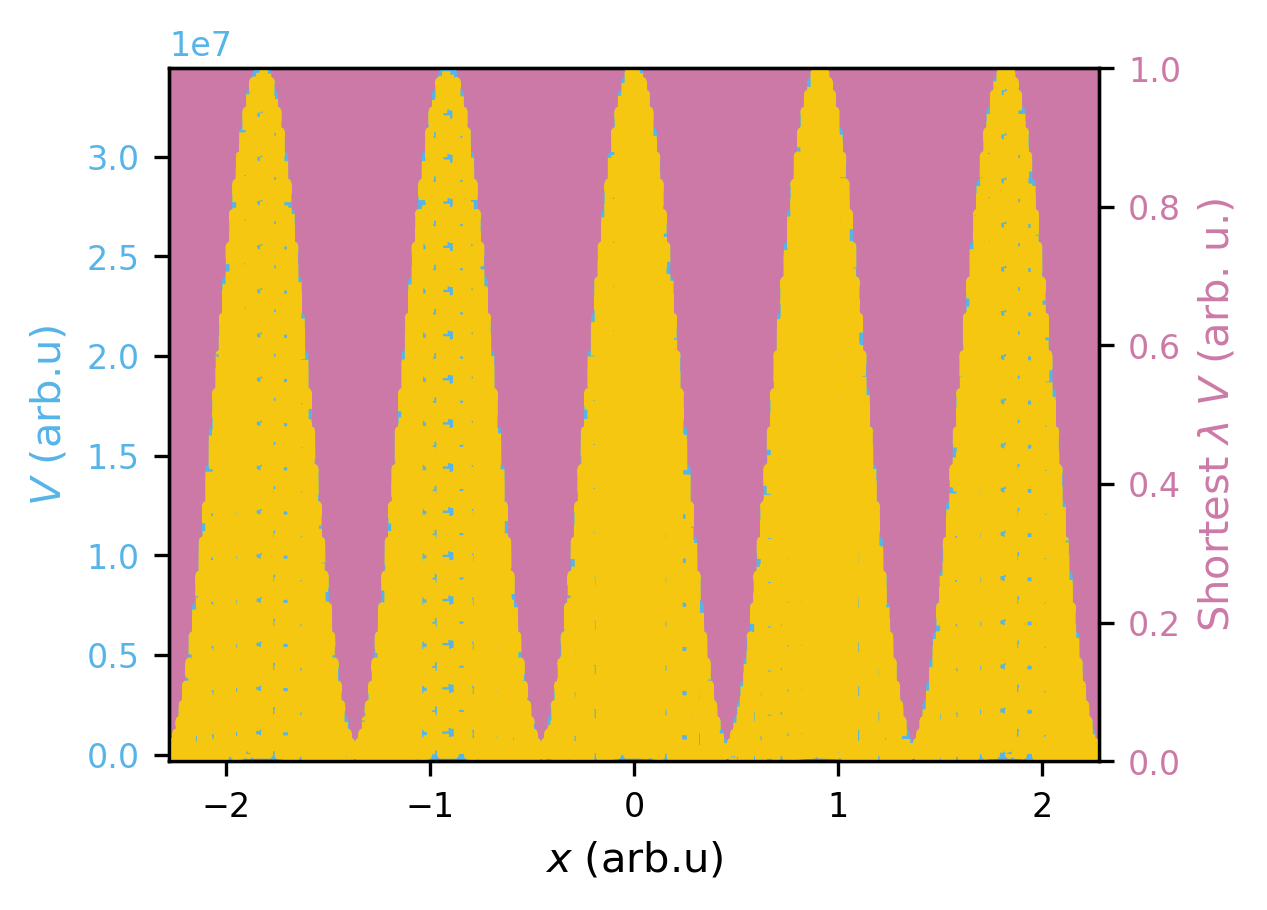

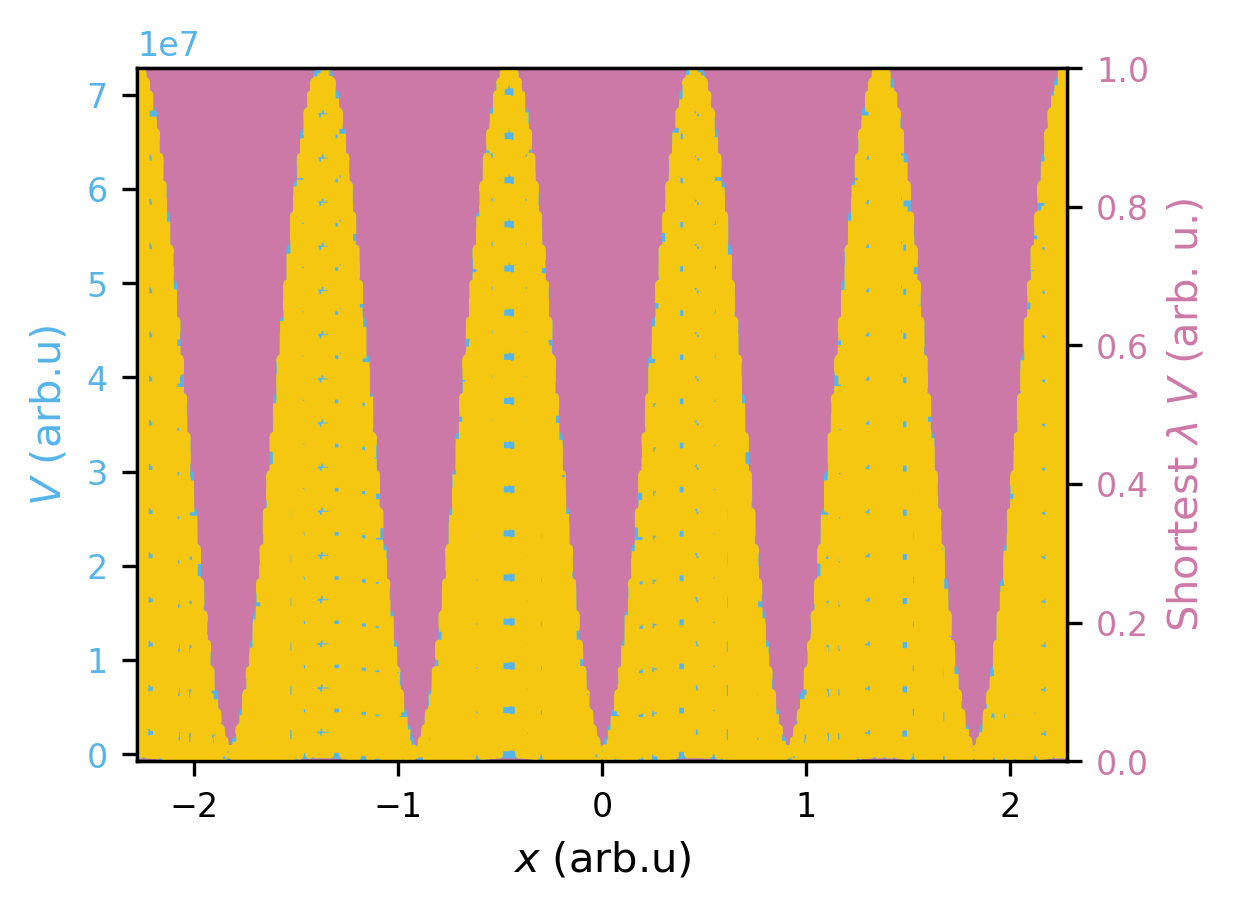

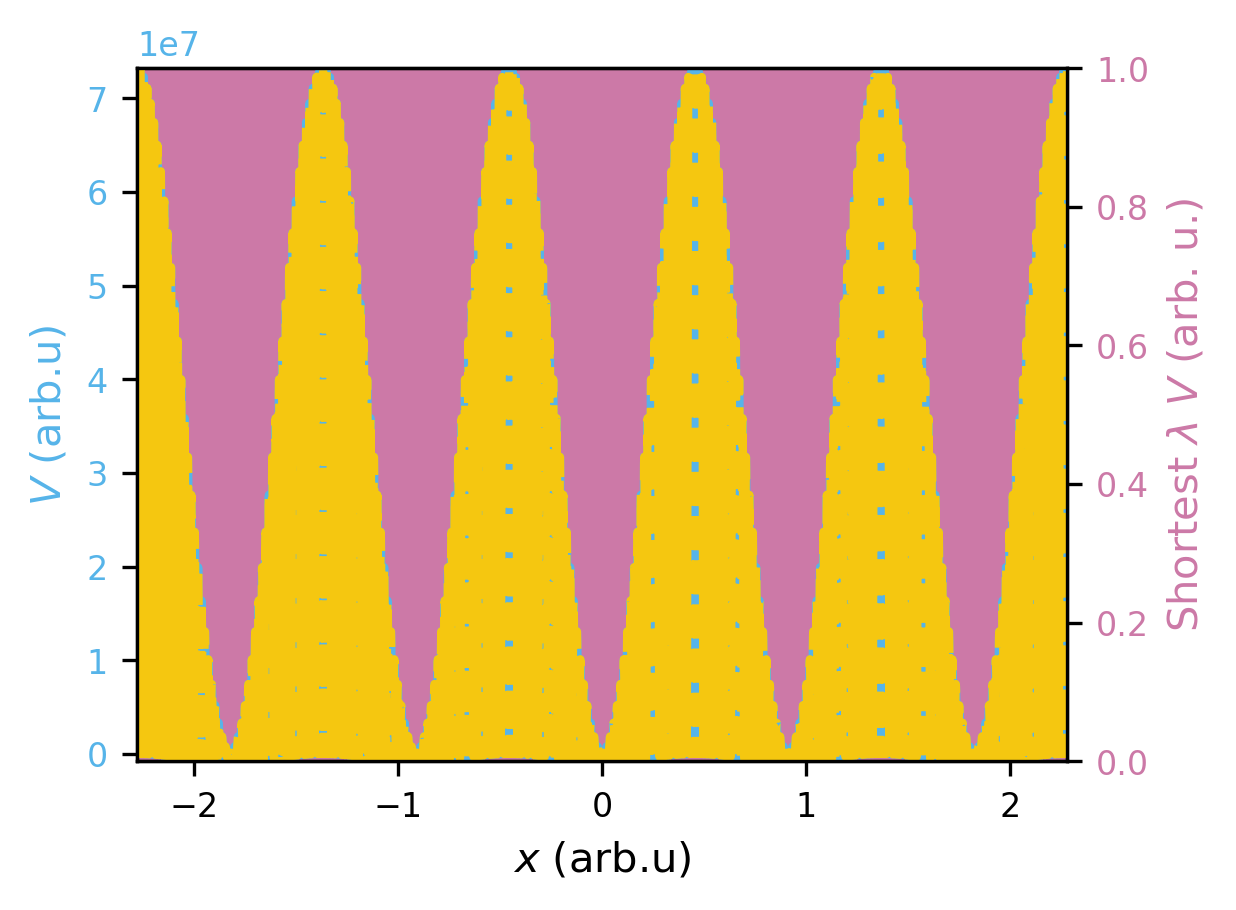

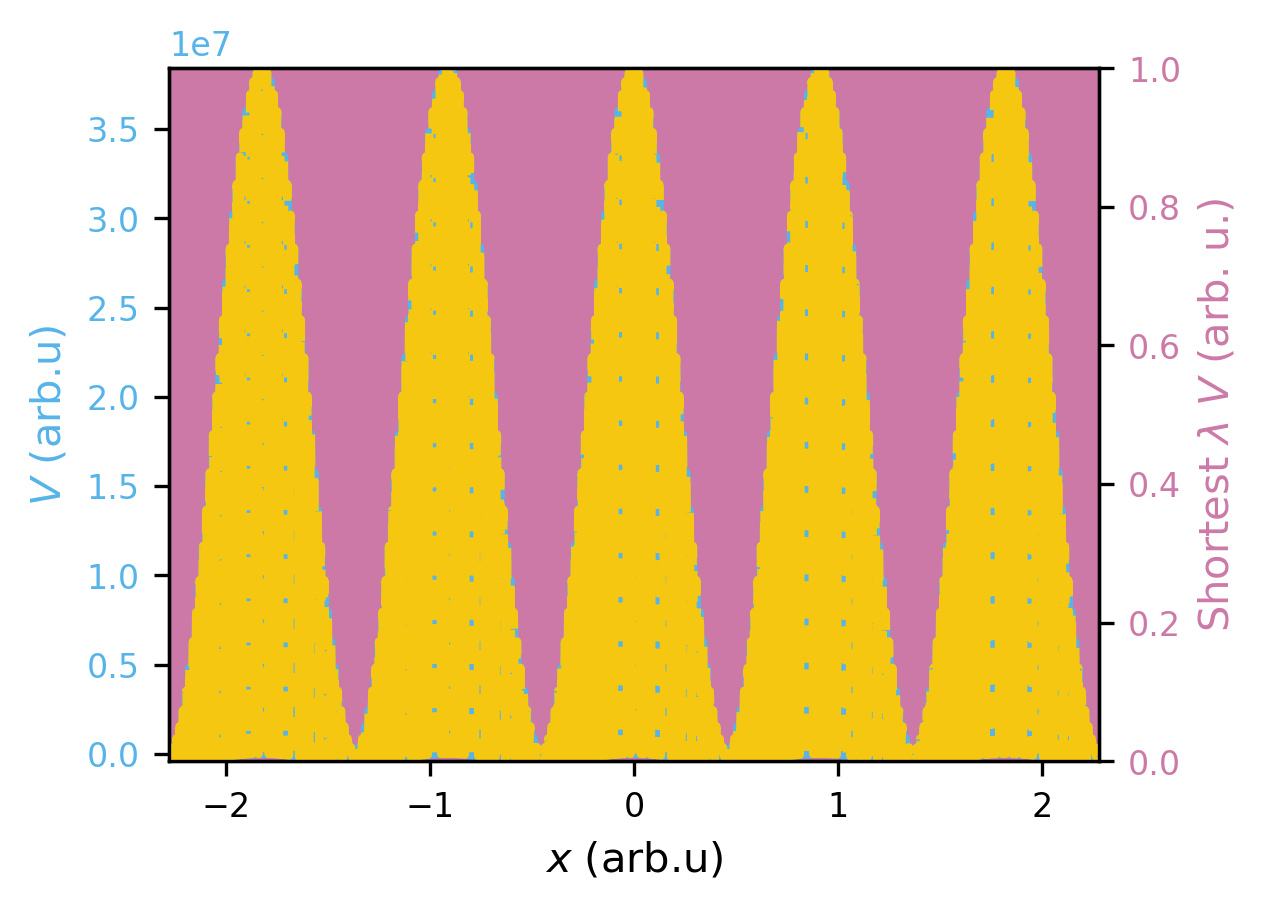

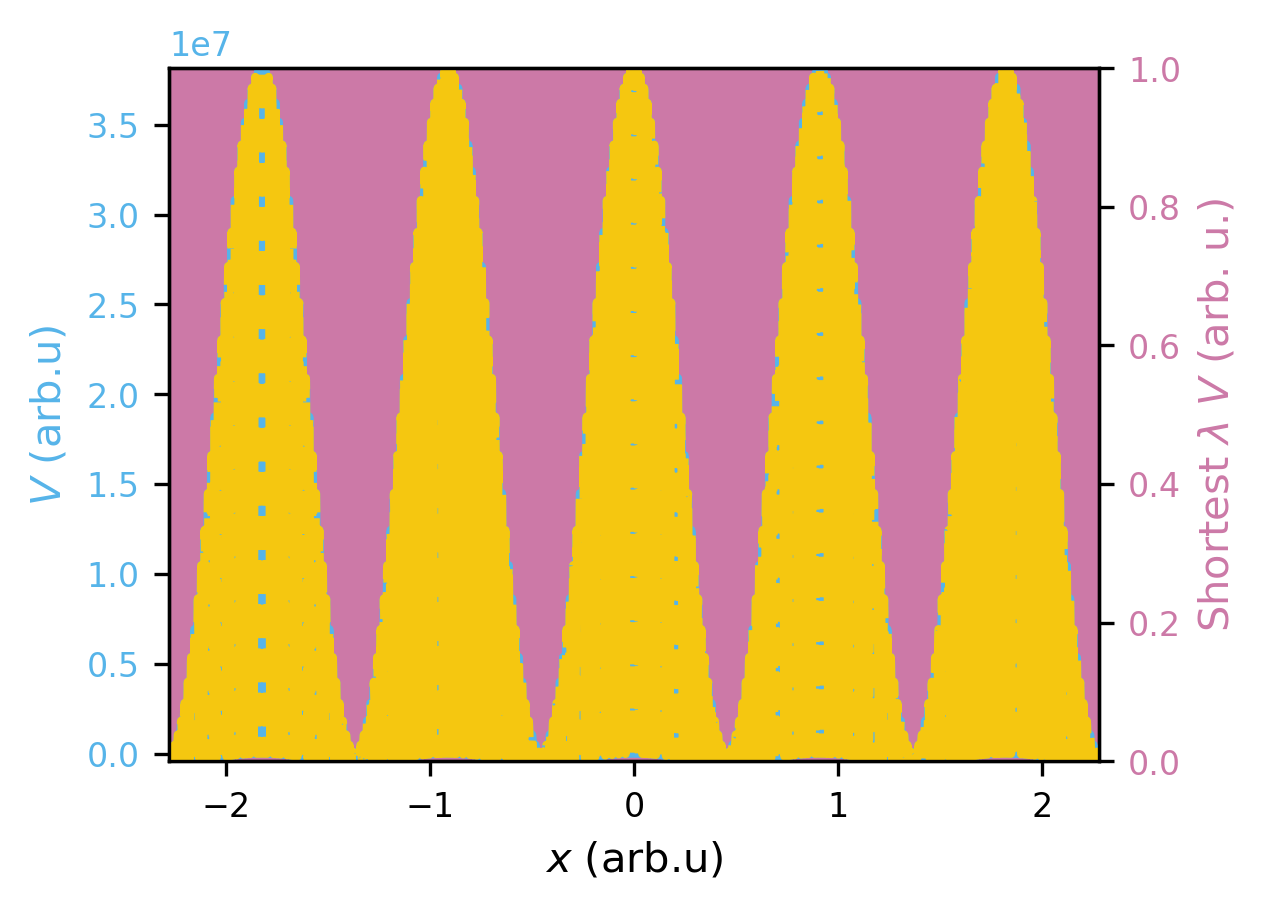

# Stop here to verify optimal solution number before proceeding

In [62]:
#########################################################################
#
# AEter visually assessing optimal Eield, declare it here 
#
#########################################################################

eval = 3
evec = vecs[:, eval]
eig_winner = np.array(-0.5 * (α1 * (evec[0] * E0 + evec[1] * E1) ** 2 
                          + α2 * (evec[2] * E2 + evec[3] * E3) ** 2
                          + α3 * (evec[4] * E4 + evec[5] * E5) ** 2
                          + (α1 + α2) * (evec[0] * E0 + evec[1] * E1) * (evec[2] * E2 + evec[3] * E3)
                          + (α1 + α3) * (evec[0] * E0 + evec[1] * E1) * (evec[4] * E4 + evec[5] * E5)
                          + (α2 + α3) * (evec[2] * E2 + evec[3] * E3) * (evec[4] * E4 + evec[5] * E5))
                 )
winner_zoom = np.array(-0.5 * (α1 * (evec[0] * f0 + evec[1] * f1) ** 2 
                          + α2 * (evec[2] * f2 + evec[3] * f3) ** 2
                          + α3 * (evec[4] * f4 + evec[5] * f5) ** 2
                          + (α1 + α2) * (evec[0] * f0 + evec[1] * f1) * (evec[2] * f2 + evec[3] * f3)
                          + (α1 + α3) * (evec[0] * f0 + evec[1] * f1) * (evec[4] * f4 + evec[5] * f5)
                          + (α2 + α3) * (evec[2] * f2 + evec[3] * f3) * (evec[4] * f4 + evec[5] * f5))
                 )



winner_combined_amps = np.array([Phi_combine_amps(evec[_+1], evec[_]) for _ in np.arange(0, len(winner_amps), 2)])
winner_combined_phases = np.array([Phi_combine_phases(evec[_+1], evec[_]) for _ in np.arange(0, len(winner_amps), 2)])

indv_fields = np.array([winner_combined_amps[_] * np.cos(k[_] * x_full - winner_combined_phases[_]) for _ in range(len(winner_combined_amps))])


scalings = np.array([get_alpha(_) for _ in λ_control])
field_scalings = np.abs(scalings[:, 0])
field_orders = scalings[:,1]
print(f'Solution is {evec}')

Solution is [-1.08115368e-26  6.05757501e+03 -4.10955550e-13 -5.98737609e+03
  6.48585069e-14  9.35339290e+00]


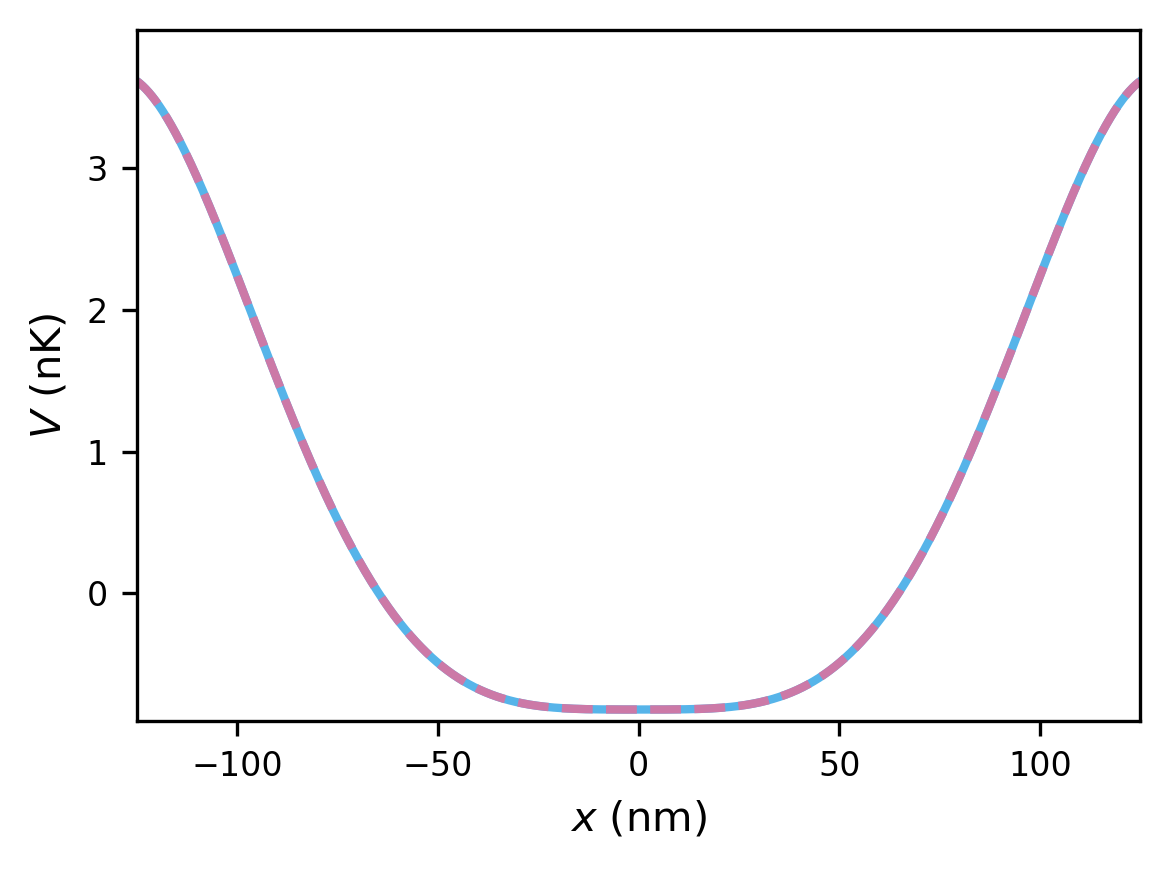

In [59]:
plt.figure()
plt.plot(gpe.convert_x(x, -9), gpe.convert_energy(eig_winner, -9), color=c1)
plt.plot(gpe.convert_x(x, -9), gpe.convert_energy(eig_winner, -9), color=c2, linestyle='--')
temp_max =  1.1*gpe.convert_energy(eig_winner, -9).max()
temp_min =  1.1*gpe.convert_energy(eig_winner, -9).min()
plt.ylabel('$V$ (nK)')
plt.xlabel('$x$ (nm)')
plt.xlim(gpe.convert_x([x[0], x[-1]], -9))
plt.ylim(temp_min, temp_max)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_AdjustedPotential_SOWINDOW.pdf')
plt.show()

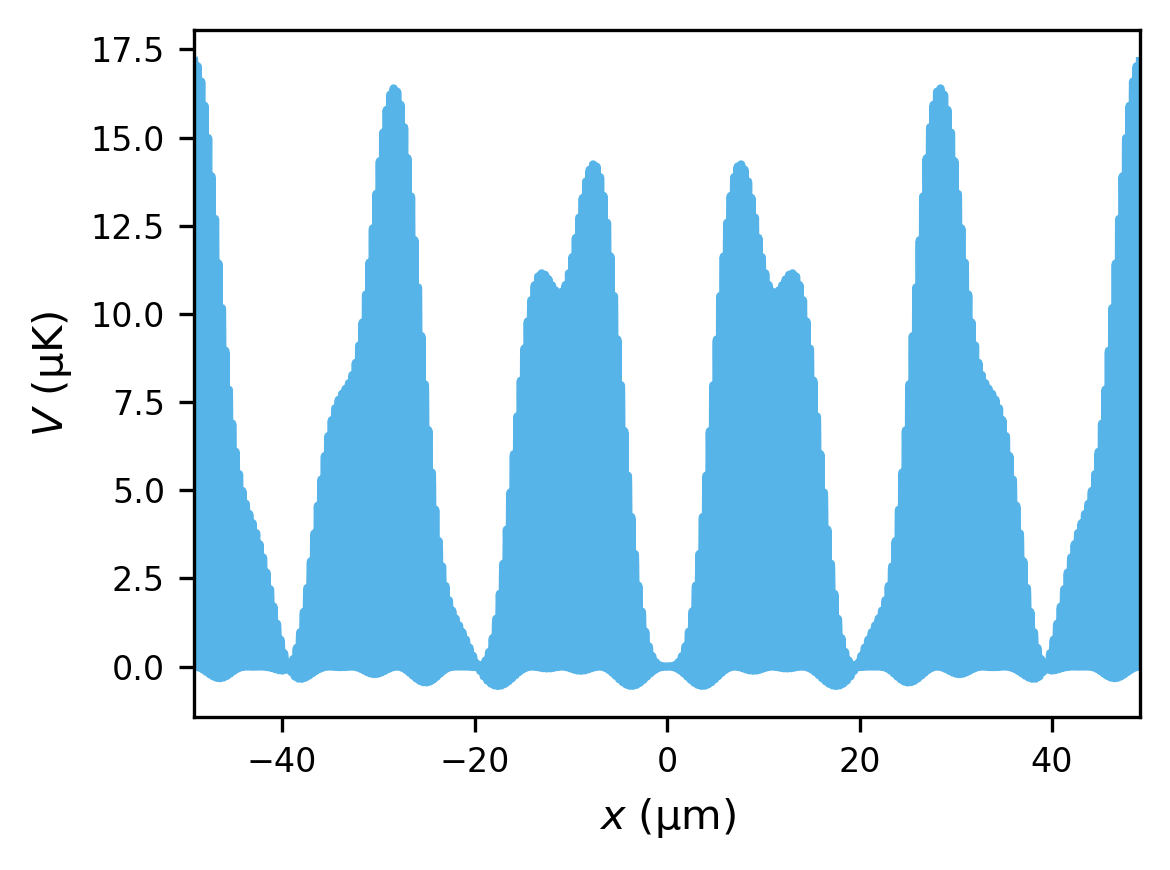

If V_0 were a single period, in full units is 0.0003450950446367529 μK*m
If we have a direct conversion factor, it would be 4.140506808933587e-09 Km
The potential maximum is 17.164518857110476


In [66]:
# Visual Assesment Modifier
vam = 16e6 #(9/0.6)*10**6
winamps = winner_amps * np.sqrt(vam)

ae_winfull = vam * winner_zoom

ae_win = vam * eig_winner



adjusted_eig_winner = ae_win.copy()
adjusted_eig_winner *= 10 ** α2_order
#adjusted_eig_winner -= min(adjusted_eig_winner)
adjusted_eig_zoom  = ae_winfull.copy()
adjusted_eig_zoom *= 10 ** α2_order
#adjusted_eig_zoom -= min(adjusted_eig_zoom)


plt.figure()
plt.plot(gpe.convert_x(x_full, -6), gpe.convert_energy(adjusted_eig_zoom, -6), color=c1)
plt.ylabel('$V$ (μK)')
plt.xlabel('$x$ (μm)')
plt.xlim(gpe.convert_x([x_full[0], x_full[-1]], -6))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_AdjustedPotential.pdf')
plt.show()

print(f'If V_0 were a single period, in full units is {simps(gpe.convert_energy(adjusted_eig_zoom, -6), dx=gpe.convert_x(dx, 0))} μK*m')
print(f'If we have a direct conversion factor, it would be {gpe.convert_x(gpe.convert_energy(vam, 0), 0)} Km')
print(f'The potential maximum is {max(gpe.convert_energy(adjusted_eig_zoom, -6))}')

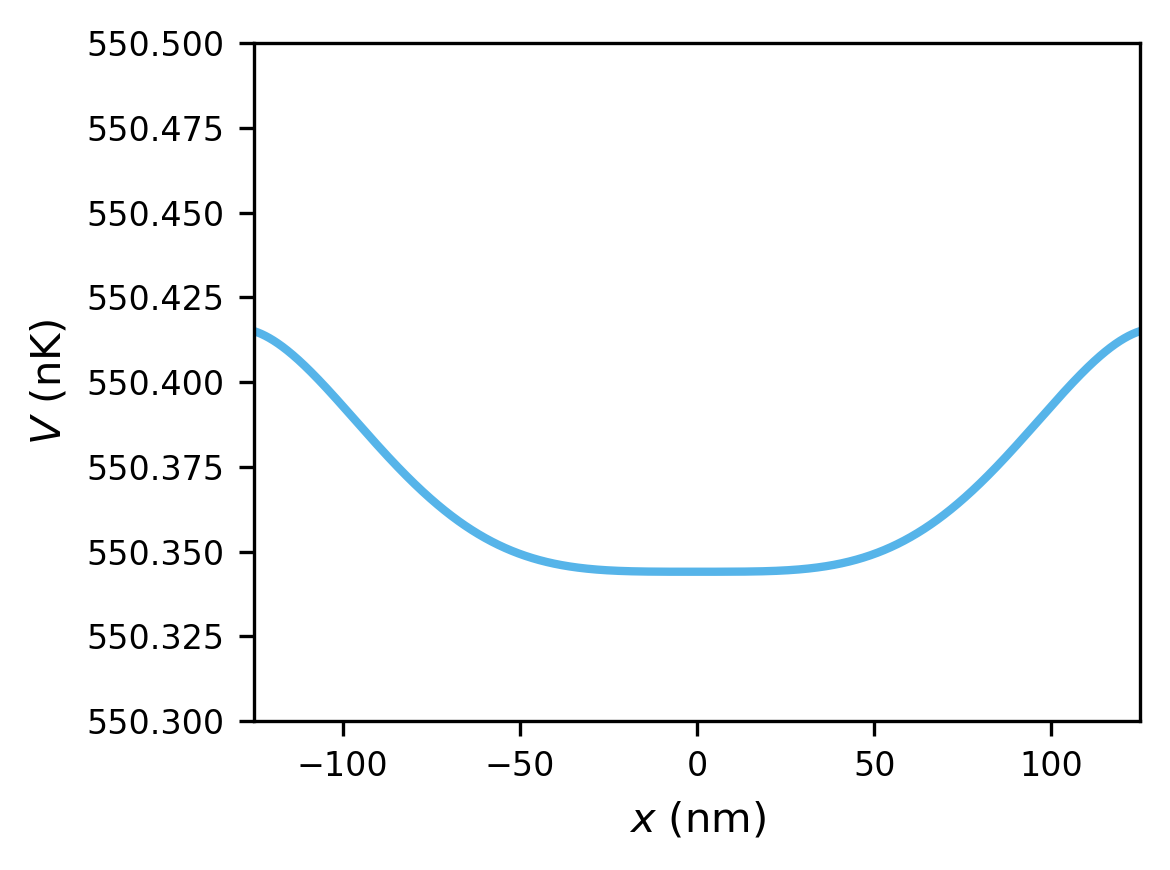

If V_0 were a single period, in full units is 0.00039918409901724375 μK*m
If we have a direct conversion factor, it would be 4.140506808933587e-09 Km
The potential maximum is 17.714876060650177


In [83]:
plt.figure()
plt.plot(gpe.convert_x(x_full, -9), gpe.convert_energy(adjusted_eig_zoom, -9), color=c1)
plt.ylabel('$V$ (nK)')
plt.xlabel('$x$ (nm)')
plt.xlim(gpe.convert_x([x[0], x[-1]], -9))
plt.ylim(550.3, 550.5)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_AdjustedPotential_SOWINDOW.pdf')
plt.show()

print(f'If V_0 were a single period, in full units is {simps(gpe.convert_energy(adjusted_eig_zoom, -6), dx=gpe.convert_x(dx, 0))} μK*m')
print(f'If we have a direct conversion factor, it would be {gpe.convert_x(gpe.convert_energy(vam, 0), 0)} Km')
print(f'The potential maximum is {max(gpe.convert_energy(adjusted_eig_zoom, -6))}')

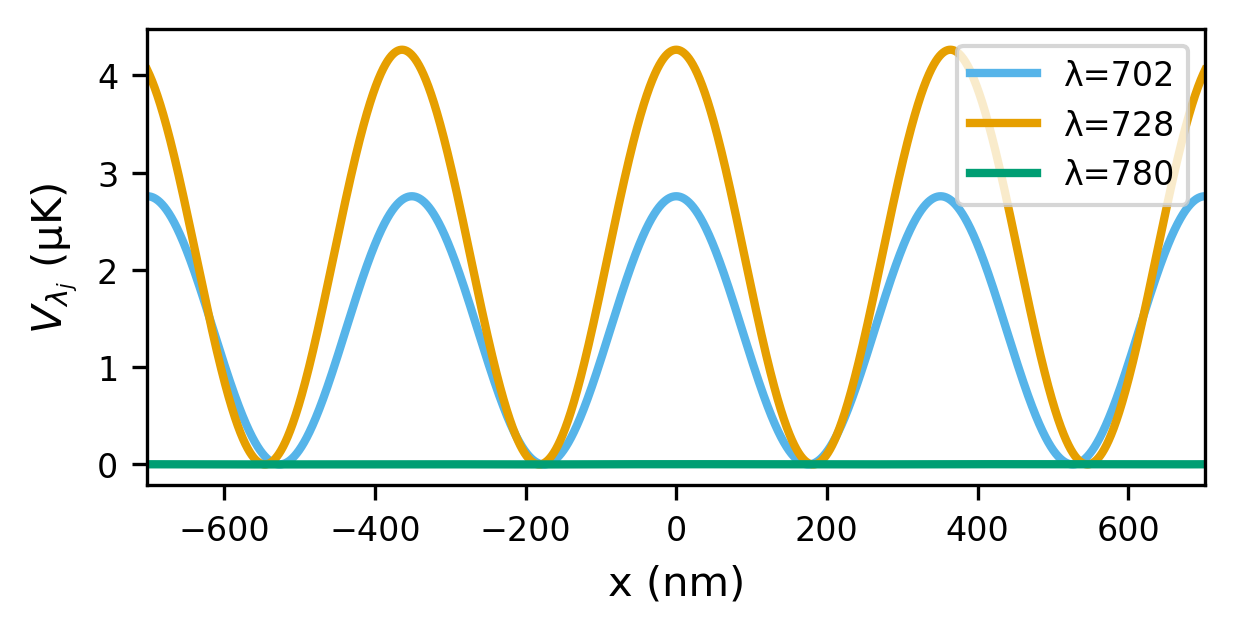

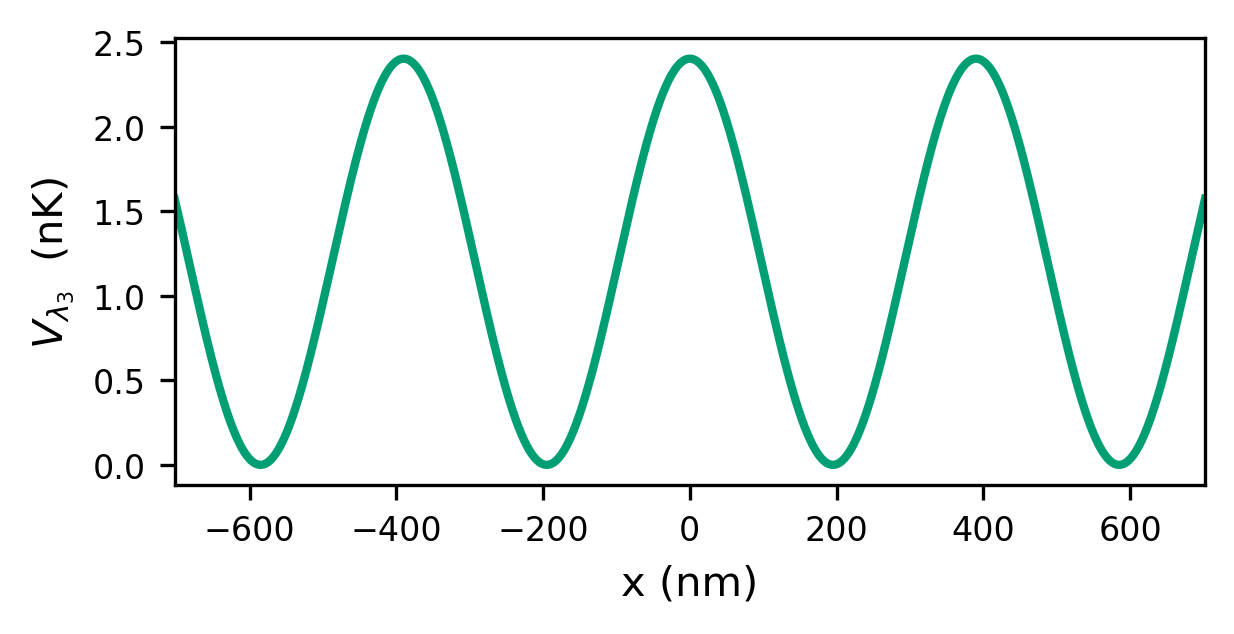

In [68]:
unit_field1 = gpe.convert_energy((-0.5 * vam * α1 * (winner_amps[0] * f0 + winner_amps[1] * f1) ** 2) * 10 ** α2_order, -6, units='K')
unit_field2 = gpe.convert_energy((-0.5 * vam * α2 * (winner_amps[2] * f2 + winner_amps[3] * f3) ** 2) * 10 ** α2_order, -6, units='K')
unit_field3 = gpe.convert_energy((-0.5 * vam * α3 * (winner_amps[4] * f4 + winner_amps[5] * f5) ** 2) * 10 ** α2_order, -6, units='K')

plt.figure(layout='constrained', figsize=(4, 2))
plt.plot(x_unitz, unit_field1, label=f'λ={λ_control[0]}')
plt.plot(x_unitz, unit_field2, label=f'λ={λ_control[1]}')
plt.plot(x_unitz, unit_field3, label=f'λ={λ_control[2]}')
plt.xlim(-λ_min, λ_min)
plt.xlabel('x (nm)')
plt.ylabel('$V_{λ_j}$ (μK)')
plt.legend()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_AllWavelengths.pdf')

plt.figure(layout='constrained', figsize=(4, 2))
plt.plot(x_unitz, 1e3*unit_field3, label=f'λ={λ_control[2]}', color=c3)
plt.xlim(-λ_min, λ_min)
plt.xlabel('x (nm)')
plt.ylabel('$V_{λ_3}$  (nK)')
#plt.legend()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_SmallestWavelength.pdf')
plt.show()

-147.69126529230505


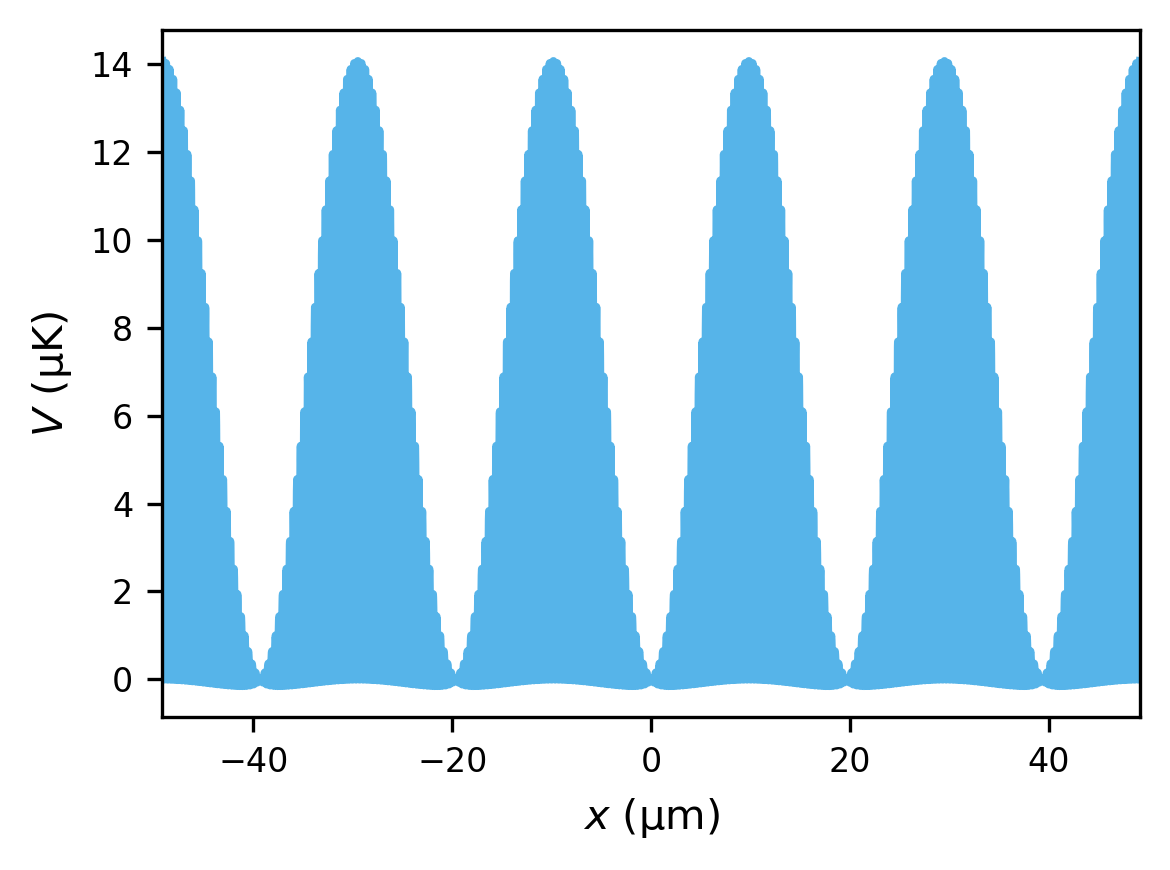

In [133]:
#######################################
# Because the third field is so small
# We try with two colors
#######################################
eig_winner_2 = -0.5 * vam *  np.array(α1 * (evec[0] * E0 + evec[1] * E1) ** 2 + α2 * (evec[2] * E2 + evec[3] * E3) ** 2
                        + (α1 + α2) * (evec[0] * E0 + evec[1] * E1) * (evec[2] * E2 + evec[3] * E3)
                        )
winner_zoom_2 = -0.5 * vam * np.array(α1 * (evec[0] * f0 + evec[1] * f1) ** 2 + α2 * (evec[2] * f2 + evec[3] * f3) ** 2
                        + (α1 + α2) * (evec[0] * f0 + evec[1] * f1) * (evec[2] * f2 + evec[3] * f3)
                         ) 

adjusted_eig_winner = eig_winner_2.copy()
adjusted_eig_winner *= 10 ** α2_order
adjusted_eig_zoom  = winner_zoom_2.copy()
adjusted_eig_zoom *= 10 ** α2_order
#adjusted_eig_zoom -= min(adjusted_eig_zoom)
#adjusted_eig_winner -= min(adjusted_eig_zoom)
print(min(gpe.convert_energy(adjusted_eig_zoom, -9)))

plt.figure()
plt.plot(gpe.convert_x(x_full, -6), gpe.convert_energy(adjusted_eig_zoom, -6), color=c1)
plt.ylabel('$V$ (μK)')
plt.xlabel('$x$ (μm)')
plt.xlim(gpe.convert_x([x_full[0], x_full[-1]], -6))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_AdjustedPotential_2field.pdf')
plt.show()

# Below is the BEC section. Please declare the field you wish to use.

In [134]:
########################################################################################################################
# The field goes here
########################################################################################################################


tags_opts = f'EigenSolution_{eval}'


op = 2


test_field_so_window, test_field_full = [adjusted_eig_winner, adjusted_eig_zoom]

test_field_so_window -= test_field_so_window.min()
test_field_full -= test_field_full.min()

test_field_tag = tags_opts




In [135]:
# Below, we cut such that we may cool a single BEC cloud in only the superoscillating potential
z_lim = gpe.dimless_x(0.5 * np.lcm.reduce([λ_control[0], λ_control[1]]), -9)
z_res = 2 ** 15
dz = 2 * z_lim / z_res
z = np.arange(-z_lim, z_lim, dz)
z_micro = gpe.convert_x(z, -6)
z_nano = gpe.convert_x(z, -9)
T = 10
times = np.linspace(0, T, 500)

# Coordinates are declared as z for ease of reading
# Coordinate x is still used when viewing SO window
# Potentials as "functions"
lcut = np.where(x_full>=-z_lim)[0][0]
rcut = np.where(x_full<=z_lim)[0][-1]
VV = UnivariateSpline(x_full[lcut:rcut], test_field_full[lcut:rcut], s=0)
vv = UnivariateSpline(x, test_field_so_window, s=0)


209714
209714
-9827.94376384489
9827.943763564936


173.36403348948127
129.65622094330678


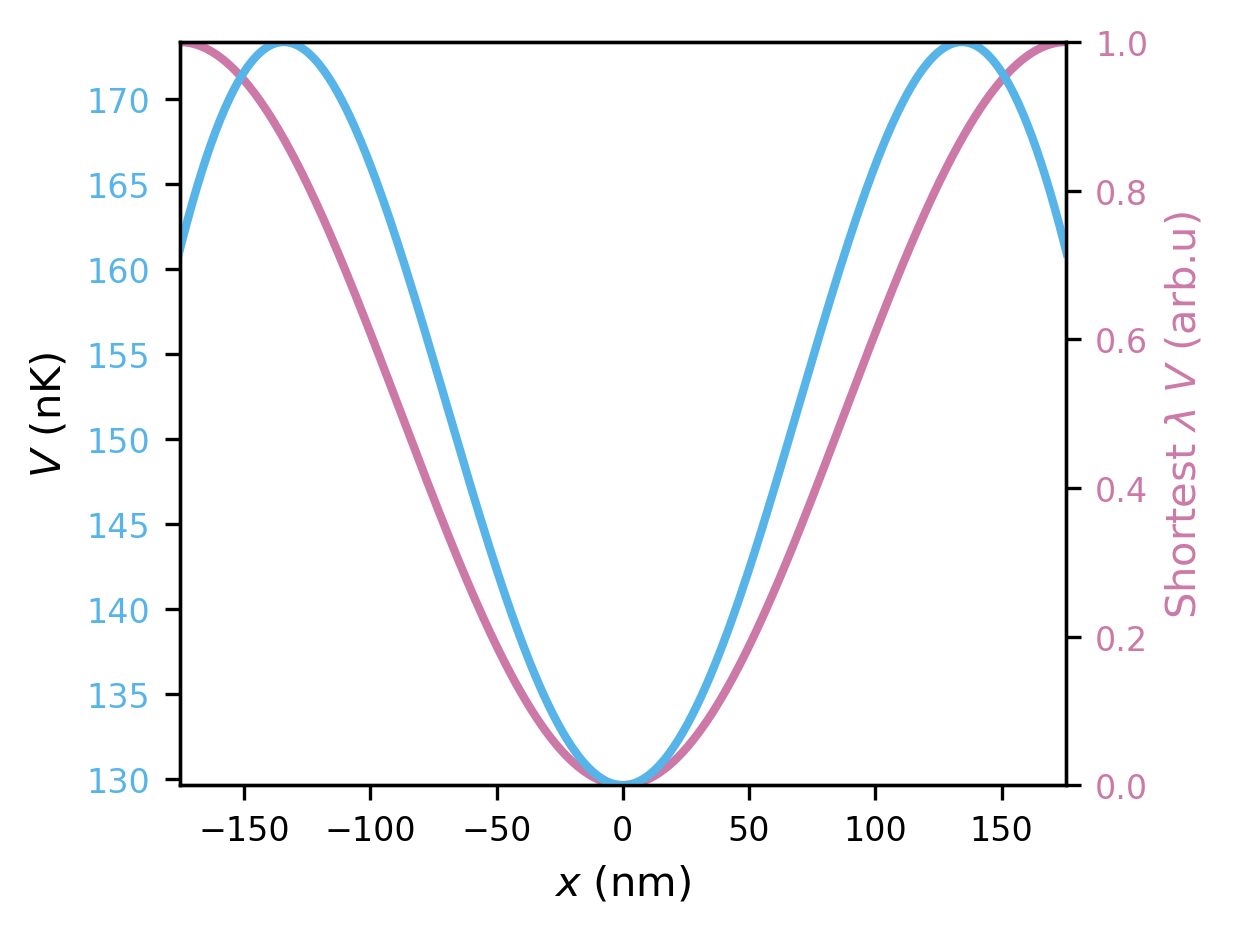

In [154]:
fig = plt.figure(layout='constrained')
region = z[np.where(z>=-gpe.dimless_x(0.25*λ_min, -9))[0][0]:np.where(z<=gpe.dimless_x(0.25*λ_min, -9))[0][-1]]
temp_max = (gpe.convert_energy(VV(region).max(), -9))
temp_min = min(gpe.convert_energy(VV(region), -9))
ax1 = fig.add_subplot(111)
ax1.plot(z_nano, gpe.convert_energy(VV(z), -9), color=c1)
ax1.set_xlim(-0.25 * λ_min, 0.25 * λ_min)

print(temp_max)
print(temp_min)
ax2 = ax1.twinx() 

ax2.plot(x_unitz, largest_freq_pulsez ** 2, color=c2)


ax1.set_zorder(1)
ax1.patch.set_visible(False)

ax1.set_ylim(temp_min, temp_max)
ax1.set_ylabel('$V$ (nK)')
ax1.tick_params(axis='y', labelcolor=c1)
ax1.set_xlabel('$x$ (nm)')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c2)
ax2.tick_params(axis='y', labelcolor=c2)    

plt.savefig(f'{file_path}/{file_name}_AdjustedPotential_Central.pdf')
plt.show()
     
         

In [18]:
print(gpe.convert_energy(max(adjusted_eig_zoom), -6))

14.206371214522935


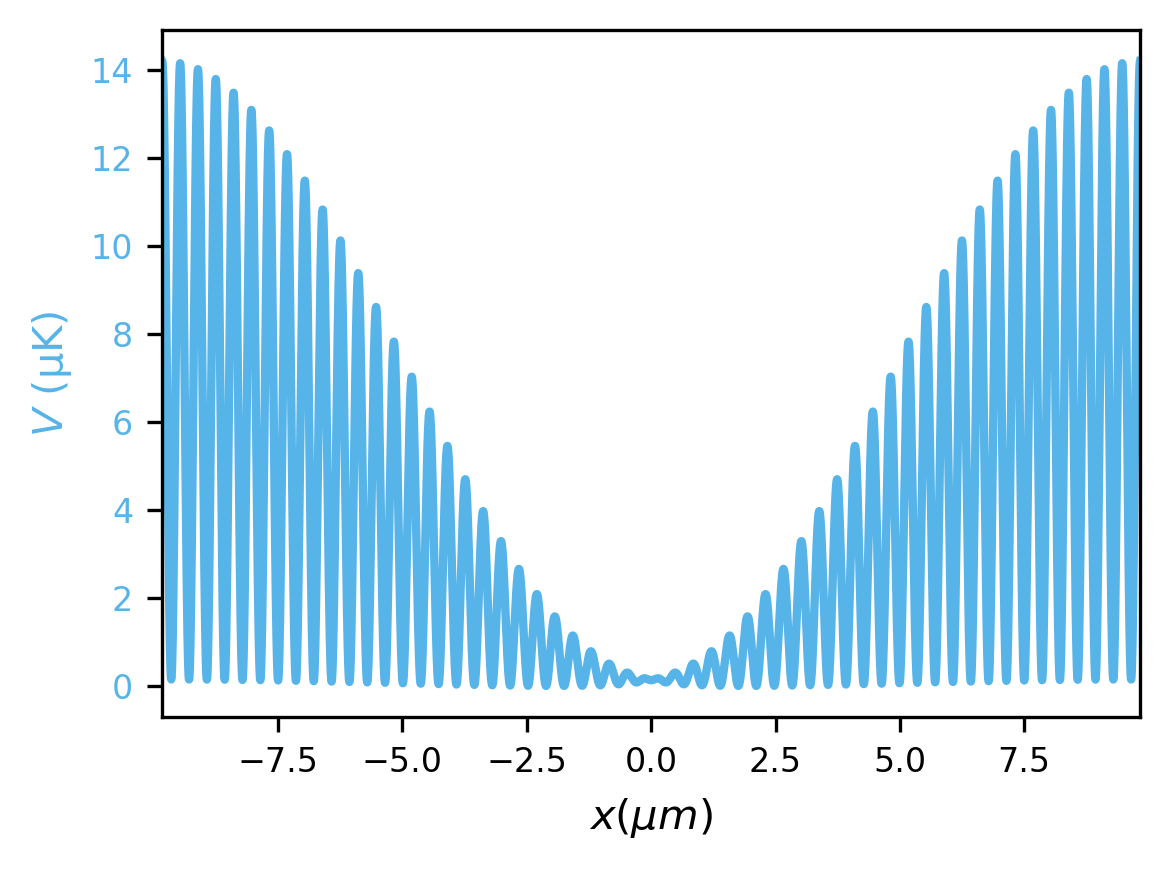

In [118]:
########################################################################################################################
# Get the BEC
########################################################################################################################


@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    

dimless_Tc = gpe.dimless_energy(T_c, -9)


@njit(parallel=True)
def first_pass_cooling(x):
    """
    Non-relativistic kinetic energy
    """
    return max(adjusted_eig_zoom) * (x / x_lim) ** 2

def fwhm(density, grid):
    index = np.where(density >= 0.5*density.max())[0]
    return grid[index[-1]] - grid[index[0]], [grid[index[0]], grid[index[-1]]]

first_pass_params = dict(
    x_amplitude=z_lim,
    x_grid_dim=z_res,
    N=N,
    k=ke,
    initial_trap=first_pass_cooling,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

sys_params = dict(
    x_amplitude=z_lim,
    x_grid_dim=z_res,
    N=N,
    k=ke,
    initial_trap=VV,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)


fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), label='SO Potential', color=c1)
ax1.set_xlabel('$x (μm)$')
ax1.set_xlim(z_micro[0], z_micro[-1])

if pre_cooling:
    ax2 = ax1.twinx()
    ax2.plot(z_micro, gpe.convert_energy(first_pass_cooling(z), -6), label='Initial Cooling Potential', color=c2)
    ax2.set_ylabel('Inititial Cooling Potential (μK)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)

ax1.set_ylabel('$V$ (μK)', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_CoolingPotential_{test_field_tag}.pdf')
plt.show()

#plt.figure()
#plt.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9))
#plt.xlim(-λ_min, λ_min)
#plt.ylim(0, 2 * max(gpe.convert_energy(sys_params['initial_trap'](x), -9)))
#plt.show()

In [119]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )
    
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        init_wavefunction=init_state,
        dt=1e-8,
        epsilon=1e-10,
        **sys_params
    )
    
    print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
    print(f'This compared to the Critical Temperature:  {T_c} nK')

In [120]:
if pre_cooling:
    init_state, E = imag_time_gpe1D(
        init_wavefunction=init_state,
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

else:
    init_state, E = imag_time_gpe1D(
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

init_state, E = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-8,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
print(f'This compared to the Critical Temperature:  {T_c} nK')

assert gpe.convert_energy(E, -9) < T_c, "This is not a BEC!, T > T_c"



Starting imaginary time propagation
current ground state energy = 3.8888e+05


Final ground state energy = 2.5319e+04

Starting imaginary time propagation
current ground state energy = 2.5319e+04
current ground state energy = 2.5319e+04
current ground state energy = 2.5319e+04
current ground state energy = 2.5319e+04


Final ground state energy = 2.5319e+04
Initial BEC Energy: 303.7794164060918 nK
This compared to the Critical Temperature:  66111.54888998118 nK


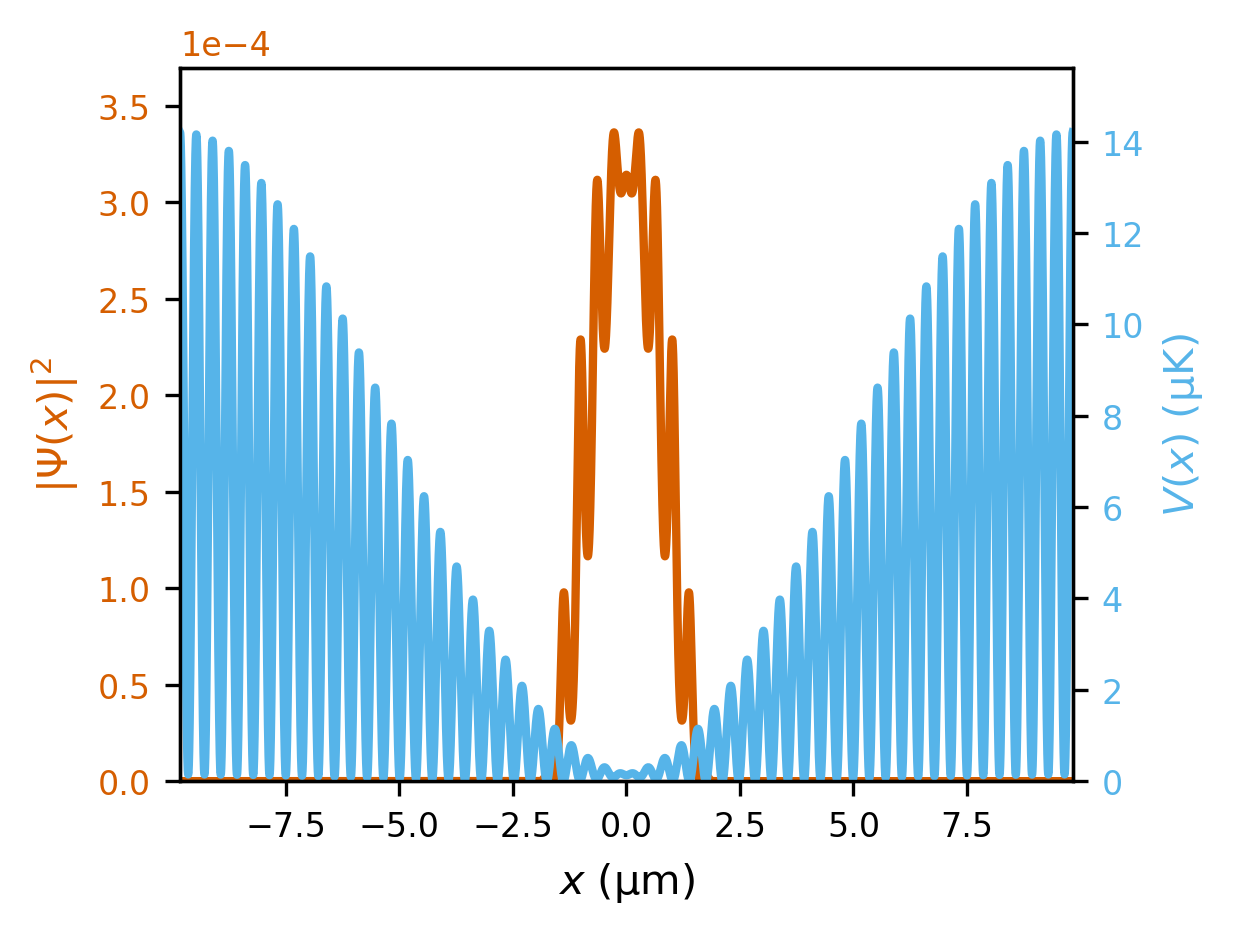

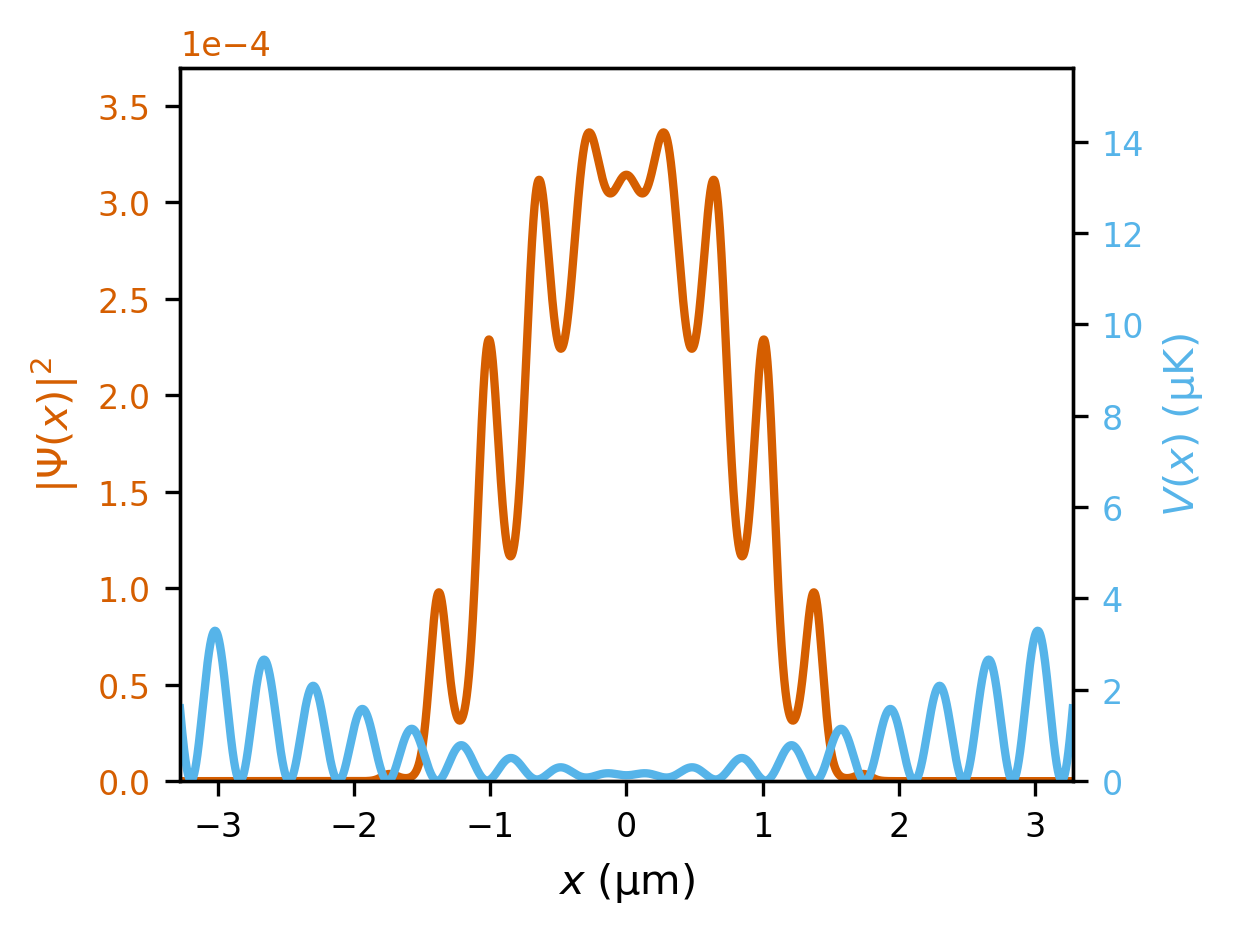

Sanity Check, the density is: 1.0


In [121]:
density = np.abs(init_state) ** 2 * dz
pmax = 1.1 * gpe.convert_energy(sys_params['initial_trap'](z), -6).max()
pmin = 0.95 * gpe.convert_energy(sys_params['initial_trap'](z), -6).min()
rat = 1/3

fig = plt.figure(layout='constrained')
ax1 = fig.add_subplot(111)
ax1.plot(z_micro, density, color=c5)
ax1.set_xlim(z_micro[0], z_micro[-1])
ax1.set_xlabel('$x$ (μm)')

ax2 = ax1.twinx()

ax2.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), color=c1)
#ax2.vlines([-1.25*λ_min/4*1e-3, 1.25*λ_min/4*1e-3], 0, pmax, linestyle='--', color=ok['black'], linewidth=1)

ax1.set_ylim(0, 1.1 * density.max())
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax2.set_ylim(0, pmax)

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.tick_params('y', labelcolor=c5)
ax2.set_ylabel('$V(x)$ (μK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])
#plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_Potential-and-Density_Wide_{test_field_tag}.pdf')
#plt.savefig(f'{file_path}/{file_name}_Potential-and-Density-Lines_{test_field_tag}.pdf')
plt.show()



fig = plt.figure(layout='constrained')
ax1 = fig.add_subplot(111)
ax1.plot(z_micro, density, color=c5)
ax1.set_xlim(z_micro[0]/3, z_micro[-1]/3)
ax1.set_xlabel('$x$ (μm)')

ax2 = ax1.twinx()

ax2.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), color=c1)

ax1.set_ylim(0, 1.1 * density.max())
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax2.set_ylim(0, pmax)

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.tick_params('y', labelcolor=c5)
ax2.set_ylabel('$V(x)$ (μK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_Potential-and-Density_{test_field_tag}.pdf')
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

In [122]:
plot_max = gpe.convert_energy(max(sys_params['initial_trap'](x)), -9)
plot_min = gpe.convert_energy(min(sys_params['initial_trap'](x)), -9)

# Input required for peak sectioning

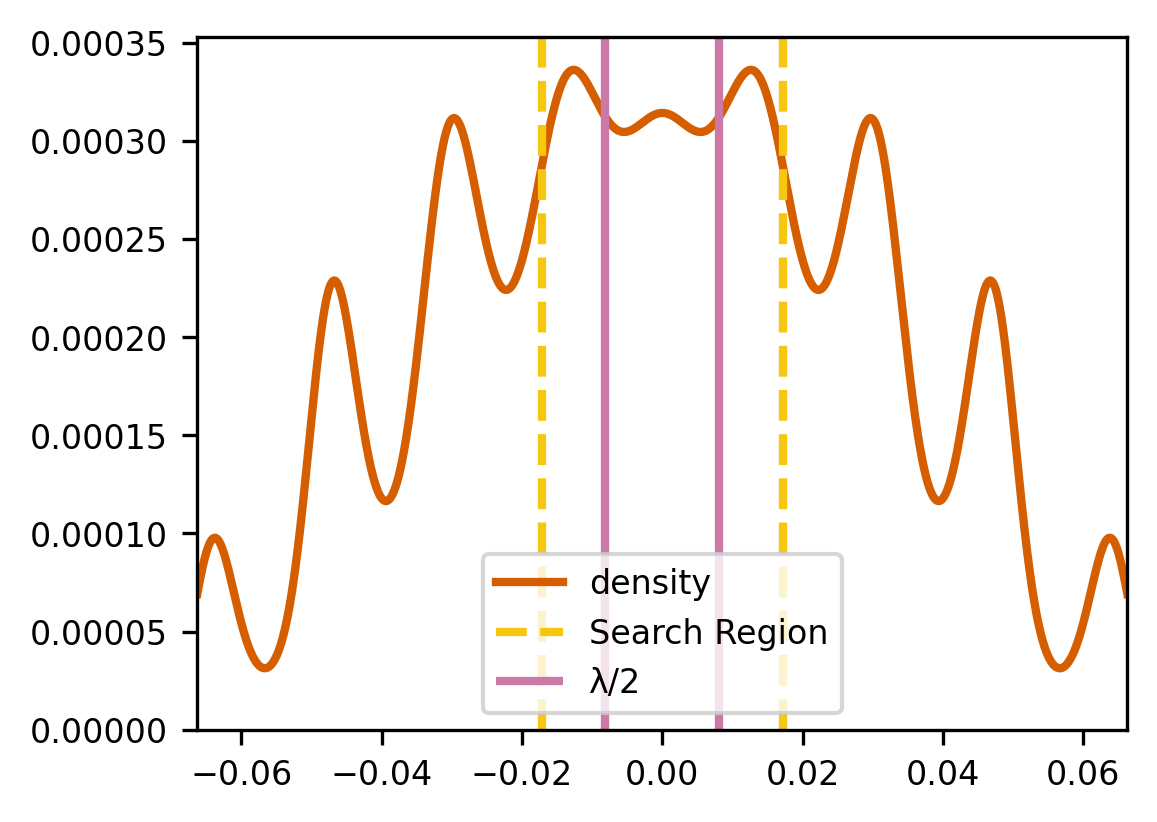

-3.8852254746757353e-13
Density peaks at 0.0003361130482412277, while the 2x minimum density at separations is 0.0006283091178540086


In [123]:
# Plot the interest area to verify the density peaks are contained entirely within
density_func = UnivariateSpline(z, density, s=0)
center_peak_loc= 0 #z[density_func(z)[0:int(len(z) /6)].argmax()]
pixi = center_peak_loc - 0.5*(np.pi/k[0]+np.pi/k[2])
pixf = center_peak_loc + 0.5*(np.pi/k[0]+np.pi/k[2]) # 0.5gpe.dimless_x(min(λ_control), -9) #
center = gpe.convert_x(center_peak_loc, -9)

plt.plot(z, density, color=c5, label='density')
plt.vlines([pixi, pixf], 0, 1.2*density.max(), color=c4, linestyle='--', label='Search Region')
plt.vlines([gpe.dimless_x(-λ_min/4, -9), gpe.dimless_x(λ_min/4, -9)], 0, plot_max, color=c2, label='λ/2')
plt.xlim(center_peak_loc- 2*(np.pi/k[0]+np.pi/k[1]), center_peak_loc+ 2*(np.pi/k[0]+np.pi/k[1]))
plt.ylim(0, 1.05*density.max())
plt.legend()
plt.show()

centerpoint=int(0.5*len(z))
print(z[centerpoint])
            
# Quick check on maxes vs peak separation
print(f'Density peaks at {density.max()}, while the 2x minimum density at separations is {2 * density_func(z[centerpoint])}')

In [124]:
# Now perform peak highlighting
n_peaks = 9
pixi = -0.07
pixf = 0.07
spa = (pixf - pixi) / n_peaks
pixf -= spa
peaks_sectioning = np.linspace(pixi, pixf, n_peaks)
print(spa)

interest_areas = [(np.array(z)[(z>=_) & (z<(_+(pixf - pixi)/n_peaks))]) for _ in peaks_sectioning]
#interest_areas = [np.array(z)[(z>=-0.025) & (z<0)], np.array(z)[(z>=0) & (z<0.025)]]
peak_locations = [_[density_func(_).argmax()] for _ in interest_areas]
confinement_distance = [np.abs(peak_locations[_+1]-peak_locations[_]) for _ in range(len(peak_locations)-1)]
print(f'Peaks are located at: {gpe.convert_x(peak_locations, -9)} nm')
print(f'Distances between these peaks are: {gpe.convert_x(confinement_distance, -9)} nm')
print(f'The confinement limit is half the field wavelength: {0.5 * λ_min} nm')
print(f'To confine beyond the transition frequency, distance must be under {0.5 * principal_wavelength} nm')

0.015555555555555557
Peaks are located at: [-1.37606396e+03 -1.00895361e+03 -6.40643555e+02 -2.72333496e+02
 -8.37986443e-09  2.72333496e+02  6.40643555e+02  1.00895361e+03
  1.37606396e+03] nm
Distances between these peaks are: [367.11035156 368.31005859 368.31005859 272.33349609 272.33349609
 368.31005859 368.31005859 367.11035156] nm
The confinement limit is half the field wavelength: 351.0 nm
To confine beyond the transition frequency, distance must be under 390.125605 nm


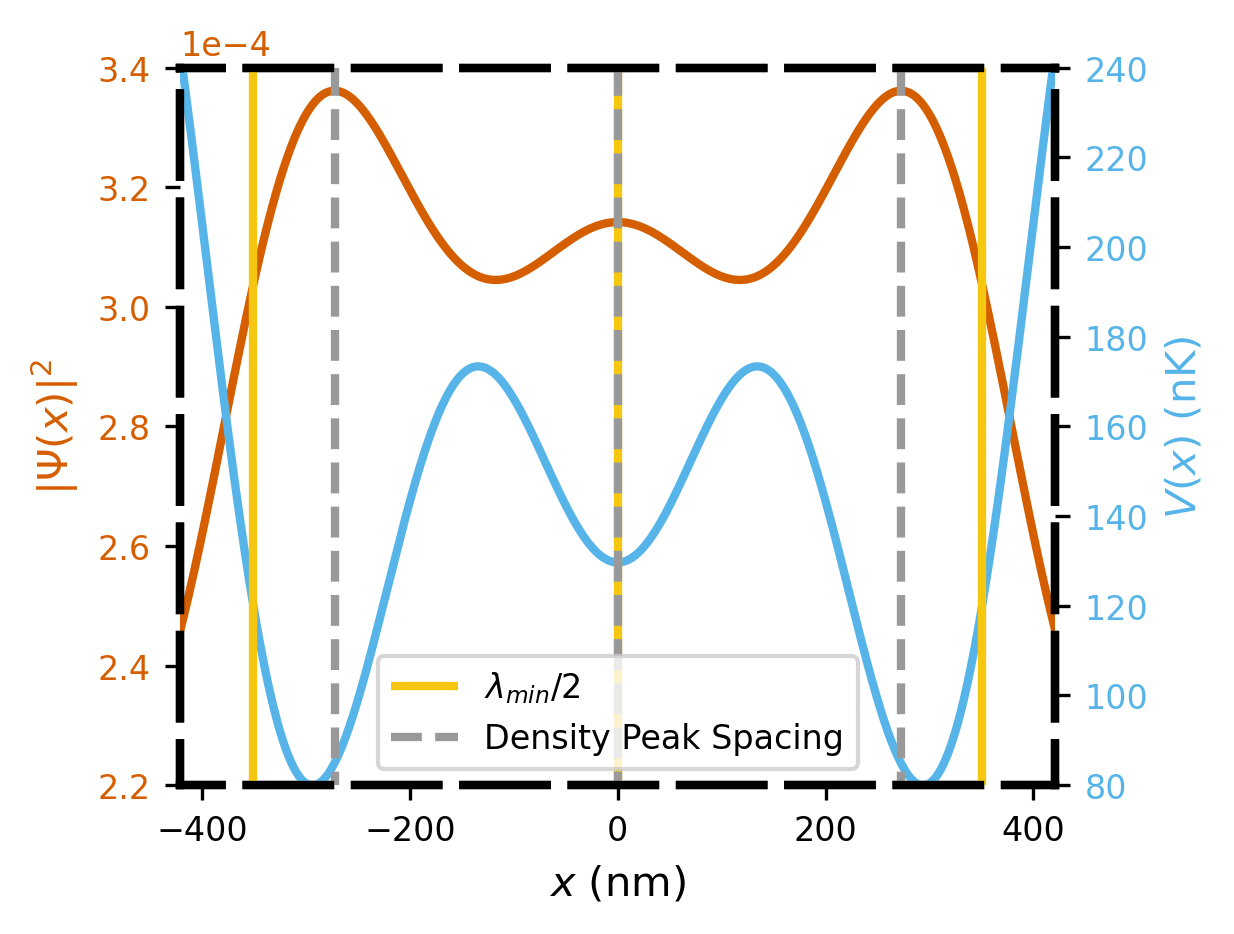

In [159]:
"""
Run this cell for peak seperation
"""
plot_min = 100
plot_max = 425
fig=plt.figure(layout='constrained')
ax1=fig.add_subplot(111)
ax1.plot(z_nano, density, color=c5, zorder=0)

#ax1.set_xlim(center-1.25*λ_min/4, center+1.25*λ_min/4)
#ax1.set_xlim(-0.75 * λ_min, 0.75 * λ_min)
ax1.set_xlim(-0.6 * λ_min, 0.6 * λ_min)
plt.setp(ax1.spines.values(), color=ok['black'], linewidth=2, linestyle=(5, (10, 3)))

ax2 = ax1.twinx()
plt.setp(ax2.spines.values(),  color=ok['black'], linewidth=2, linestyle=(5, (10, 3)))
ax2.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9))
ax2.vlines([-λ_min/2, 0, λ_min/2], 0, plot_max, color=ok['amber'], label='$λ_{min}$/2')
ax2.vlines(gpe.convert_x(peak_locations, -9), 0, plot_max, color=ok['grey'], linestyle='--', label='Density Peak Spacing')
ax2.add_patch(patches.FancyArrowPatch(
    (-λ_min/2, 0.95*plot_max), 
    (0, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (0, 0.95*plot_max), 
    (λ_min/2, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(peak_locations[3], -9), 0.9*plot_max), 
    (gpe.convert_x(peak_locations[4], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
ax2.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(peak_locations[4], -9), 0.9*plot_max), 
    (gpe.convert_x(peak_locations[5], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)


ax1.set_ylim(2.2e-4, 3.4e-4)
ax2.set_ylim(80, 240)
ax2.legend(loc='lower center').set_zorder(10)
ax2.set_ylabel('$V(x)$ (nK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax1.tick_params('y', labelcolor=c5)

ax1.set_xlabel('$x$ (nm)')
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_ResultsWithPeaks_{test_field_tag}_Zoom.pdf')
plt.show()

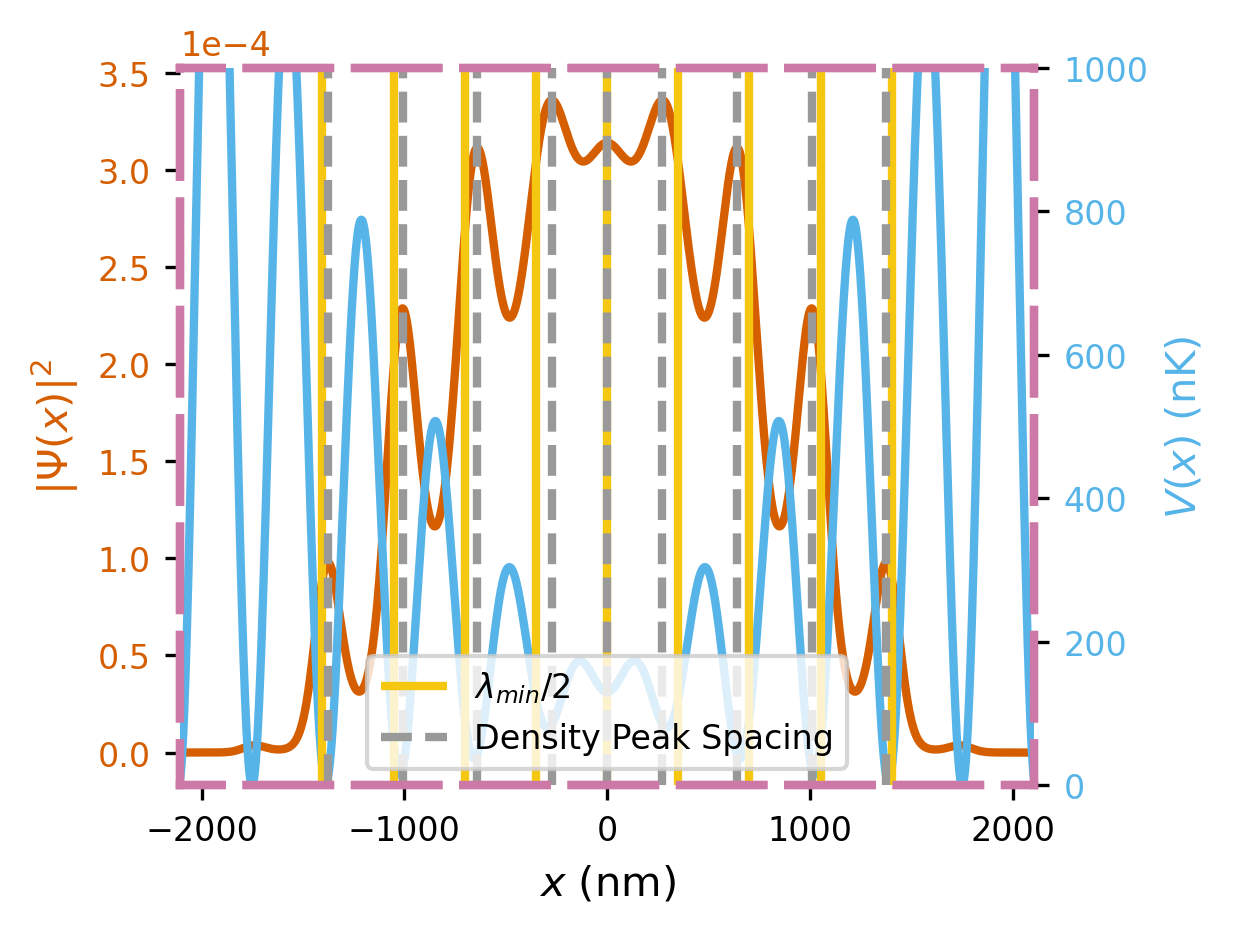

In [126]:
"""
Run this cell for peak seperation
"""
plot_min = 0
plot_max = 1000
fig=plt.figure(layout='constrained')
ax1=fig.add_subplot(111)
ax1.plot(z_nano, density, color=c5, zorder=0)

#ax1.set_xlim(center-1.25*λ_min/4, center+1.25*λ_min/4)
ax1.set_xlim(-3*λ_min, 3*λ_min)
plt.setp(ax1.spines.values(), color=ok['purple'], linewidth=2, linestyle=(5, (10, 3)))

ax2 = ax1.twinx()
plt.setp(ax2.spines.values(),  color=ok['purple'], linewidth=2, linestyle=(5, (10, 3)))
ax2.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9))
ax2.vlines([-2*λ_min, -1.5*λ_min, -λ_min, -λ_min/2, 0, λ_min/2, λ_min, 1.5*λ_min, 2*λ_min], 0, plot_max, color=ok['amber'], label='$λ_{min}$/2')
ax2.vlines(gpe.convert_x(peak_locations, -9), 0, plot_max, color=ok['grey'], linestyle='--', label='Density Peak Spacing')
"""ax2.add_patch(patches.FancyArrowPatch(
    (-λ_min, 0.95*plot_max), 
    (-λ_min/2, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (-λ_min/2, 0.95*plot_max), 
    (0, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (0, 0.95*plot_max), 
    (λ_min/2, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (λ_min/2, 0.95*plot_max), 
    (λ_min, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(peak_locations[0], -9), 0.9*plot_max), 
    (gpe.convert_x(peak_locations[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
ax2.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(peak_locations[1], -9), 0.9*plot_max), 
    (gpe.convert_x(peak_locations[2], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)"""



ax2.set_ylim(plot_min, plot_max)
ax2.legend(loc='lower center').set_zorder(10)
ax2.set_ylabel('$V(x)$ (nK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax1.tick_params('y', labelcolor=c5)

ax1.set_xlabel('$x$ (nm)')
plt.savefig(f'{file_path}/{file_name}_Eval{eval}_ResultsWithPeaks_{test_field_tag}.pdf')
plt.show()

In [155]:
# As a final step, get the amplitude in units of both Joules per alpha and nK per alpha
A_1 = np.sqrt(winamps[0] ** 2 + winamps[1] ** 2)
A_2 = np.sqrt(winamps[2] ** 2 + winamps[3] ** 2)
A_3 = np.sqrt(winamps[4] ** 2 + winamps[5] ** 2)
print(f'The amplitudes in dimensionless units are {A_1} and {A_2}')
A_1_sqJ = gpe.convert_energy(A_1 ** 2, 0, units='J')
A_2_sqJ = gpe.convert_energy(A_2 ** 2, 0, units='J')
A_3_sqJ = gpe.convert_energy(A_3 ** 2, 0, units='J')
A_1_units = gpe.convert_energy((α1 * 10 ** (α2_order)) * A_1 ** 2, 0, units='J')
A_2_units = gpe.convert_energy((α2 * 10 ** (α2_order)) * A_2 ** 2, 0, units='J')
A_3_units = gpe.convert_energy((α3 * 10 ** (α2_order)) * A_3 ** 2, 0, units='J')
A_1_sqK = gpe.convert_energy(A_1 ** 2, 0, units='K')
A_2_sqK = gpe.convert_energy(A_2 ** 2, 0, units='K')
A_3_sqK = gpe.convert_energy(A_3 ** 2, 0, units='K')
spaced_out = gpe.convert_x(confinement_distance, -9)
space_ratio = spaced_out / (0.5 * λ_min)

print(f'The amplitudes squared in Joules per units alpha are {A_1_sqJ}, {A_2_sqJ}, and {A_3_sqJ}')
print(f'The α_j * A_J ** 2 in Joules are {A_1_units}, {A_2_units}, and {A_3_units}')
print(f'The amplitudes squared in Kelvin per units alpha are {A_1_sqK}, {A_2_sqK}, and {A_3_sqK}')
print(f"The maximum height of the potential is {gpe.convert_energy(sys_params['initial_trap'](z), -6).max()} μK")
print(f"The maximum height of the central potential is {gpe.convert_energy(sys_params['initial_trap'](region), -9).max()} nK")
print(f"The spacing between peaks is {spaced_out} nm, or roughly {[round(_, 4) for _ in space_ratio]}*λ_min/2")
#print(f"Also of note is the ratio to the transition wavelength {round(spaced_out / (0.5 * principal_wavelength), 3)}*λ_0/2")

The amplitudes in dimensionless units are 24230300.03955249 and 23949504.36712908
The amplitudes squared in Joules per units alpha are 9.725537707678899e-20, 9.501432741351686e-20, and 2.3187523967102456e-25
The α_j * A_J ** 2 in Joules are -7.612947166682943e-29, -1.177225518059698e-28, and -6.631167139815933e-32
The amplitudes squared in Kelvin per units alpha are 7044.178286935274, 6881.859720574661, and 0.01679465524336921
The maximum height of the potential is 14.206371214508225 μK
The maximum height of the central potential is 173.36403348948127 nK
The spacing between peaks is [367.11035156 368.31005859 368.31005859 272.33349609 272.33349609
 368.31005859 368.31005859 367.11035156] nm, or roughly [1.0459, 1.0493, 1.0493, 0.7759, 0.7759, 1.0493, 1.0493, 1.0459]*λ_min/2


In [128]:
print(f"Of note, the entire set of peaks spans {np.sum(spaced_out)}, which is compared to {0.5 * (n_peaks-1) * λ_min} nm, or {int(0.5 * (n_peaks-1))}λ_min")
print(f"This leads to the total ratio {round(np.sum(spaced_out) / (0.5 * (n_peaks-1) * λ_min), 5)}λ_min/2")

Of note, the entire set of peaks spans 2752.127929685153, which is compared to 2808.0 nm, or 4λ_min
This leads to the total ratio 0.9801λ_min/2


In [129]:
print(f"This leads to the total ratio {round(np.sum(spaced_out) / (0.5*λ_min), 5)}λ_min/2")

This leads to the total ratio 7.84082λ_min/2
